PCA on spectra of late tyoe stars. Main idea is to use that as input for suppervised learning on metallicities because only a small fraction has metallicity labels. The unlabelled onces should help to find the featurees (wavlength) sensitive to metallicity. 

In [1]:
import time

import numpy as np

import scipy as sp

import pandas as pd
#npt all is actually used now
from scipy import stats
from scipy.stats import norm, skew #for some statistics
from scipy.special import boxcox1p
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

#PCA
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import seaborn as sns

from astropy.io import fits
#for cross correlation
from PyAstronomy import pyasl

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

2022-11-02 11:26:49.934710: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-02 11:26:49.934750: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Loading the features (spectra) and the labels. For now we look mainly on the label velocity because the velocity causes shifts between features. Thus the velocity needs to be found and then used to shift the spectra.

In [8]:
path='/home/tobias/ml-testing/spectra-ML/met-cal-22/'
vel=np.loadtxt(path+'finvel_exp_st_v2_combined.txt').T
print(f"shape of targets: {np.shape(vel)}")
#columns are, main target is v_los
colnames=['spec_quality','v_los','ev_fullcorr','ev_specparts','early','ev_final','corr_max','s/n','id_cub','id_ifu','id_prim','cub_quality']
print(f"target columns {colnames}")
#get spectra, the features, they are normalized already, likely not prefectly but should be o.k. for a first iterartion
#they are in fits data cubes, the ids address the locations
hbin=fits.open(path+'st1_atm_norm_cont_corr.fits.gz')
spec1n=hbin[0].data
hbin.close()
hbin=fits.open(path+'st2_atm_norm_cont_corr.fits.gz')
spec2n=hbin[0].data
hbin.close()
hbin=fits.open(path+'st3_atm_norm_cont_corr.fits.gz')
spec3n=hbin[0].data
hbin.close()
hbin=fits.open(path+'st4_atm_norm_cont_corr.fits.gz')
spec4n=hbin[0].data
hbin.close()
print(f"shape of feature cubes: {np.shape(spec4n)}")
#select the stars with velocities, all are of about the same type currently 
#also have s/n of 20 to avoid problems 
velg=np.zeros((np.shape(vel)[0],6000))
#put the spectra in the same shape as the velcicties
x=np.zeros((3072,6000))
#snlimit, we use only spectra were the noise does not dominate the signal 
snlim=40
cg=0
for i in range(np.shape(vel)[1]):
    #select stars which have velocities and sufficient s/n that by it caused problems are unlikely
    if vel[0,i]>0 and vel[11,i]>-0.5:
        if vel[10,i]==1 and np.median(spec1n[828:1950,int(vel[9,i]-1),int(vel[8,i]-1)])>0 and np.std(sp.ndimage.gaussian_filter(spec1n[828:1950,int(vel[9,i]-1),int(vel[8,i]-1)],1)-spec1n[828:1950,int(vel[9,i]-1),int(vel[8,i]-1)])<1/snlim:
            x[:,cg]=spec1n[:,int(vel[9,i]-1),int(vel[8,i]-1)]
            sm=np.std(sp.ndimage.gaussian_filter(spec1n[828:1950,int(vel[9,i]-1),int(vel[8,i]-1)],1)-spec1n[828:1950,int(vel[9,i]-1),int(vel[8,i]-1)])
            velg[:,cg]=vel[:,i]
            velg[7,cg]=1/sm  
            velg[4,cg]=1 #data source 1
            cg+=1
        if vel[10,i]==2 and np.median(spec2n[828:1950,int(vel[9,i]-1),int(vel[8,i]-1)])>0 and np.std(sp.ndimage.gaussian_filter(spec2n[828:1950,int(vel[9,i]-1),int(vel[8,i]-1)],1)-spec2n[828:1950,int(vel[9,i]-1),int(vel[8,i]-1)])<1/snlim:
            x[:,cg]=spec2n[:,int(vel[9,i]-1),int(vel[8,i]-1)]
            sm=np.std(sp.ndimage.gaussian_filter(spec2n[828:1950,int(vel[9,i]-1),int(vel[8,i]-1)],1)-spec2n[828:1950,int(vel[9,i]-1),int(vel[8,i]-1)])            
            velg[:,cg]=vel[:,i]
            velg[7,cg]=1/sm  
            velg[4,cg]=1 #data source 1            
            cg+=1
        if vel[10,i]==3 and np.median(spec3n[828:1950,int(vel[9,i]-1),int(vel[8,i]-1)])>0 and np.std(sp.ndimage.gaussian_filter(spec3n[828:1950,int(vel[9,i]-1),int(vel[8,i]-1)],1)-spec3n[828:1950,int(vel[9,i]-1),int(vel[8,i]-1)])<1/snlim:
            x[:,cg]=spec3n[:,int(vel[9,i]-1),int(vel[8,i]-1)]
            sm=np.std(sp.ndimage.gaussian_filter(spec3n[828:1950,int(vel[9,i]-1),int(vel[8,i]-1)],1)-spec3n[828:1950,int(vel[9,i]-1),int(vel[8,i]-1)])
            velg[:,cg]=vel[:,i]
            velg[7,cg]=1/sm  
            velg[4,cg]=1 #data source 1            
            cg+=1
        if vel[10,i]==4 and np.median(spec4n[828:1950,int(vel[9,i]-1),int(vel[8,i]-1)])>0 and np.std(sp.ndimage.gaussian_filter(spec4n[828:1950,int(vel[9,i]-1),int(vel[8,i]-1)],1)-spec4n[828:1950,int(vel[9,i]-1),int(vel[8,i]-1)])<1/snlim:
            x[:,cg]=spec4n[:,int(vel[9,i]-1),int(vel[8,i]-1)] 
            sm=np.std(sp.ndimage.gaussian_filter(spec4n[828:1950,int(vel[9,i]-1),int(vel[8,i]-1)],1)-spec4n[828:1950,int(vel[9,i]-1),int(vel[8,i]-1)])
            velg[:,cg]=vel[:,i]
            velg[7,cg]=1/sm  
            velg[4,cg]=1 #data source 1            
            cg+=1
print(f"number of good spectra (only 2020 nuclear): {cg} ")
#add 2018 observations
#barycentric correction, 3 is the correction row is expoure id-1
bar=np.loadtxt(path+'pos_time_2b.txt').T
print(f"shape of barycentric correction file {np.shape(bar)}")
path18='/home/tobias/ml-testing/spectra-ML/2018/'
hbin=fits.open(path18+'st1_atm_norm_cont_corr.v3.fits.gz')
spec1na=hbin[0].data
hbin.close()
hbin=fits.open(path18+'st2_atm_norm_cont_corr.v3.fits.gz')
spec2na=hbin[0].data
hbin.close()
hbin=fits.open(path18+'st3_atm_norm_cont_corr.v3.fits.gz')
spec3na=hbin[0].data
hbin.close()
hbin=fits.open(path18+'st4_atm_norm_cont_corr.v3.fits.gz')
spec4na=hbin[0].data
hbin.close()
data3=np.loadtxt(path+'source_spec_cat_v2b.txt').T
for i in range(np.shape(data3)[1]):
    #all not early and yso stars with spectra and velocities 
    if data3[20,i]>0 and data3[46,i]>0 and data3[55,i]==0 and data3[54,i]==0:
        #get all spectra of each source
        for j in range(int(data3[17,i])):
            #get ids to address them 
            yc=data3[20+j,i]#row id
            xc=data3[28,i]#column id
            zc=data3[29,i] #file id
      
            if int(zc)==1  and np.median(spec1na[828:1950,int(xc-1),int(yc-1)])>0 and np.std(sp.ndimage.gaussian_filter(spec1na[828:1950,int(xc-1),int(yc-1)],1)-spec1na[828:1950,int(xc-1),int(yc-1)])<1/snlim:
                x[:,cg]=spec1na[:,int(xc-1),int(yc-1)]
                sm=np.std(sp.ndimage.gaussian_filter(spec1na[828:1950,int(xc-1),int(yc-1)],1)-spec1na[828:1950,int(xc-1),int(yc-1)])
                velg[7,cg]=1/sm #noise level 
                velg[2:3,cg]=data3[46,i] # velocity is error is from combined spectrum not necessary correct
                velg[5,cg]=data3[46,i]
                velg[1,cg]=data3[45,i]+bar[3,int(yc-1)] #velocity in telescope reference frame back corrected from barycentric
                velg[4,cg]=2 #data source 2
                velg[8,cg]=yc
                velg[9,cg]=xc
                velg[10,cg]=zc                
                cg+=1
            if int(zc)==2  and np.median(spec2na[828:1950,int(xc-1),int(yc-1)])>0  and np.std(sp.ndimage.gaussian_filter(spec2na[828:1950,int(xc-1),int(yc-1)],1)-spec2na[828:1950,int(xc-1),int(yc-1)])<1/snlim:
                x[:,cg]=spec2na[:,int(xc-1),int(yc-1)]
                sm=np.std(sp.ndimage.gaussian_filter(spec2na[828:1950,int(xc-1),int(yc-1)],1)-spec2na[828:1950,int(xc-1),int(yc-1)])
                velg[7,cg]=1/sm #noise level 
                velg[2:3,cg]=data3[46,i] # velocity is error is from combined spectrum not necessary correct
                velg[5,cg]=data3[46,i]
                velg[1,cg]=data3[45,i]+bar[3,int(yc-1)] #velocity in telescope reference frame back corrected from barycentric
                velg[4,cg]=2 #data source 2
                velg[8,cg]=yc
                velg[9,cg]=xc
                velg[10,cg]=zc   
                cg+=1
            if int(zc)==3  and np.median(spec3na[828:1950,int(xc-1),int(yc-1)])>0  and np.std(sp.ndimage.gaussian_filter(spec3na[828:1950,int(xc-1),int(yc-1)],1)-spec3na[828:1950,int(xc-1),int(yc-1)])<1/snlim:
                x[:,cg]=spec3na[:,int(xc-1),int(yc-1)]
                sm=np.std(sp.ndimage.gaussian_filter(spec3na[828:1950,int(xc-1),int(yc-1)],1)-spec3na[828:1950,int(xc-1),int(yc-1)])
                velg[7,cg]=1/sm #noise level 
                velg[2:3,cg]=data3[46,i] # velocity is error is from combined spectrum not necessary correct
                velg[5,cg]=data3[46,i]
                velg[1,cg]=data3[45,i]+bar[3,int(yc-1)] #velocity in telescope reference frame back corrected from barycentric   
                velg[4,cg]=2 #data source 2
                velg[8,cg]=yc
                velg[9,cg]=xc
                velg[10,cg]=zc   
                cg+=1
            if int(zc)==4  and np.median(spec4na[828:1950,int(xc-1),int(yc-1)])>0  and np.std(sp.ndimage.gaussian_filter(spec4na[828:1950,int(xc-1),int(yc-1)],1)-spec4na[828:1950,int(xc-1),int(yc-1)])<1/snlim:
                x[:,cg]=spec4na[:,int(xc-1),int(yc-1)]
                sm=np.std(sp.ndimage.gaussian_filter(spec4na[828:1950,int(xc-1),int(yc-1)],1)-spec4na[828:1950,int(xc-1),int(yc-1)])
                velg[7,cg]=1/sm #noise level 
                velg[2:3,cg]=data3[46,i] # velocity is error is from combined spectrum not necessary correct
                velg[5,cg]=data3[46,i]
                velg[1,cg]=data3[45,i]+bar[3,int(yc-1)] #velocity in telescope reference frame back corrected from barycentric
                velg[4,cg]=2 #data source 2
                velg[8,cg]=yc
                velg[9,cg]=xc
                velg[10,cg]=zc   
                cg+=1                
   
print(f"number of good spectra (all nuclear) is {cg}")  #with limit of 30 it is 3867, 40 is 3784
#now addition calibration spectra
calv=np.loadtxt(path+"finvel_cal_exp_st_v2_combined.txt").T

hbin=fits.open(path+'st1_cal_atm_norm_cont_corr.fits.gz')
spec1c=hbin[0].data
hbin.close()
hbin=fits.open(path+'st2_cal_atm_norm_cont_corr.fits.gz')
spec2c=hbin[0].data
hbin.close()
hbin=fits.open(path+'st3_cal_atm_norm_cont_corr.fits.gz')
spec3c=hbin[0].data
hbin.close()

for i in range(np.shape(calv)[1]):
    #only exclude early stars velocities are done here again 
    if  calv[4,i]<0.5:
        if calv[10,i]==1 and np.median(spec1c[828:1950,int(calv[9,i]-1),int(calv[8,i]-1)])>0 and np.std(sp.ndimage.gaussian_filter(spec1c[828:1950,int(calv[9,i]-1),int(calv[8,i]-1)],1)-spec1c[828:1950,int(calv[9,i]-1),int(calv[8,i]-1)])<1/snlim:
            x[:,cg]=spec1c[:,int(calv[9,i]-1),int(calv[8,i]-1)]
            sm=np.std(sp.ndimage.gaussian_filter(spec1c[828:1950,int(calv[9,i]-1),int(calv[8,i]-1)],1)-spec1c[828:1950,int(calv[9,i]-1),int(calv[8,i]-1)])
            velg[:,cg]=calv[:,i]
            velg[7,cg]=1/sm  
            velg[4,cg]=3 #data source 3
            cg+=1
        if calv[10,i]==2 and np.median(spec2c[828:1950,int(calv[9,i]-1),int(calv[8,i]-1)])>0 and np.std(sp.ndimage.gaussian_filter(spec2c[828:1950,int(calv[9,i]-1),int(calv[8,i]-1)],1)-spec2c[828:1950,int(calv[9,i]-1),int(calv[8,i]-1)])<1/snlim:
            x[:,cg]=spec2c[:,int(calv[9,i]-1),int(calv[8,i]-1)]
            sm=np.std(sp.ndimage.gaussian_filter(spec2c[828:1950,int(calv[9,i]-1),int(calv[8,i]-1)],1)-spec2c[828:1950,int(calv[9,i]-1),int(calv[8,i]-1)])
            velg[:,cg]=calv[:,i]
            velg[7,cg]=1/sm  
            velg[4,cg]=3 #data source 3
            cg+=1  
        if calv[10,i]==3 and np.median(spec3c[828:1950,int(calv[9,i]-1),int(calv[8,i]-1)])>0 and np.std(sp.ndimage.gaussian_filter(spec3c[828:1950,int(calv[9,i]-1),int(calv[8,i]-1)],1)-spec3c[828:1950,int(calv[9,i]-1),int(calv[8,i]-1)])<1/snlim:
            x[:,cg]=spec3c[:,int(calv[9,i]-1),int(calv[8,i]-1)]
            sm=np.std(sp.ndimage.gaussian_filter(spec3c[828:1950,int(calv[9,i]-1),int(calv[8,i]-1)],1)-spec3c[828:1950,int(calv[9,i]-1),int(calv[8,i]-1)])
            velg[:,cg]=calv[:,i]
            velg[7,cg]=1/sm  
            velg[4,cg]=3 #data source 3
            cg+=1              
print(f"number of good spectra (all): {cg} ")            
#exclude empty part
velg=velg[:,1:cg] #1 there by mistake 
x=x[:,1:cg]
print(f"shape of feature data now: {np.shape(x)}")
#still need to get real noise needs tom be smooth subtract in that case 

shape of targets: (12, 636)
target columns ['spec_quality', 'v_los', 'ev_fullcorr', 'ev_specparts', 'early', 'ev_final', 'corr_max', 's/n', 'id_cub', 'id_ifu', 'id_prim', 'cub_quality']
shape of feature cubes: (3072, 24, 31)
number of good spectra (only 2020 nuclear): 427 
shape of barycentric correction file (4, 145)
number of good spectra (all nuclear) is 3785
number of good spectra (all): 4033 
shape of feature data now: (3072, 4032)


In [9]:
#get some summary statistic
res=np.zeros((9,3072))
for i in range(3072):
    res[0,i]=i
    res[1,i]= np.count_nonzero(x[i]==0)/cg #number of zeros 
    res[3,i]=1.92499995231628+i* 0.000187174489838071  #wavelength in micron 
    res[2,i]=np.mean(x[i])
    res[4,i]=np.median(x[i])  
    res[5,i]=np.quantile(x[i],0.05)    
    res[6,i]=np.quantile(x[i],0.25)  
    res[7,i]=np.quantile(x[i],0.75)  
    res[8,i]=np.quantile(x[i],0.95)      
#data is normalized between 2.08 and 2.29 micron corresponds to x
print(f"data is normalized between feature {res[0,np.argmin(abs(res[3]-2.08))]} and {res[0,np.argmin(abs(res[3]-2.29))]}")        

data is normalized between feature 828.0 and 1950.0


Text(0, 0.5, 'feature')

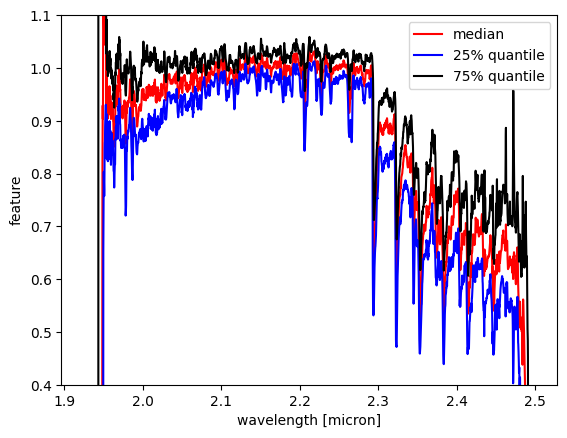

In [10]:
plt.plot(res[3],res[4],'r-',label='median')
plt.plot(res[3],res[6],'b-',label='25% quantile')
plt.plot(res[3],res[7],'k-',label='75% quantile')
plt.legend(loc="best")
plt.ylim(0.4,1.1)
plt.xlabel("wavelength [micron]")
plt.ylabel("feature")

Text(0, 0.5, 'feature')

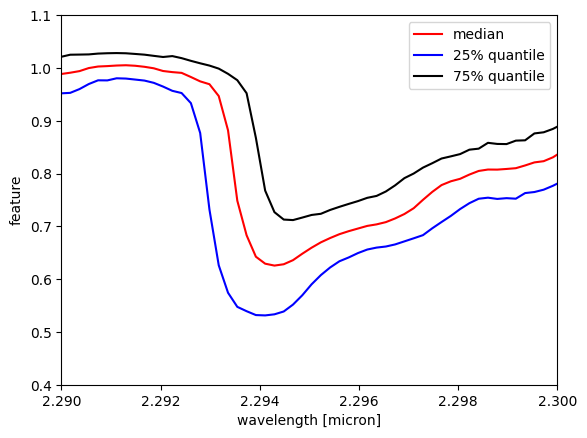

In [11]:
plt.plot(res[3],res[4],'r-',label='median')
plt.plot(res[3],res[6],'b-',label='25% quantile')
plt.plot(res[3],res[7],'k-',label='75% quantile')
plt.legend(loc="best")
plt.ylim(0.4,1.1)
plt.xlim(2.29,2.30)
plt.xlabel("wavelength [micron]")
plt.ylabel("feature")

Data was normalized between 2.08 and 2.29 that explains the smaller variation there. On small scales some variation is because of varying velocity cases shifting see the plot zoomed on 2.295 and the kmeans analysis in xx2.  In principle the already included velocity should account for it, but was discovered in xxx that it does not always work. Therefore we do it here again using cross correlation in python.  

template [0.9624704  0.9945561  1.0099745  ... 0.8944892  0.89602625 0.92251045]
template range corresponds to feature of spectra 1382.0 to 2650.0
wavelength axis of template is [2.18000007 2.18010007 2.18020007 ... 2.4248     2.4249     2.425     ]
checking if shape are the same
(1266,)
(1266,)
(2451,)
(2451,)
fit on spectrum 1
 best correlation of 966.2533493550123 at 76.0 km/s
 past velocity is 77.5 km/s


Text(0, 0.5, 'feature')

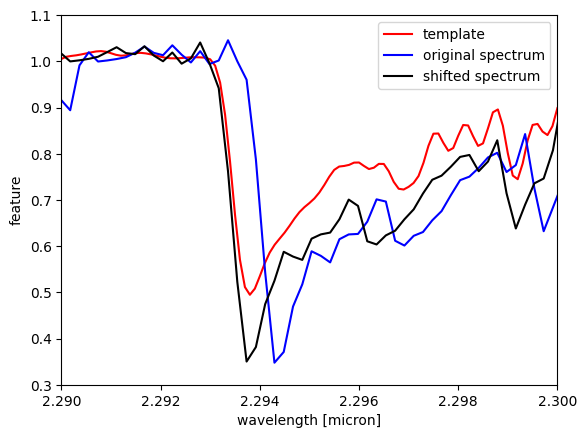

In [12]:
path='/home/tobias/ml-testing/spectra-ML/met-cal-22/'
hbin=fits.open(path+'smh_hd63425B_v15c.fits')
templ=hbin[0].data
hbin.close()
print(f"template {templ}")
print(f"template range corresponds to feature of spectra {res[0,np.argmin(abs(res[3]*(1-500/299000)-2.18))]} to {res[0,np.argmin(abs(res[3]*(1+500/299000)-2.425))]}")
wt=np.arange(2.1800000667572,2.1800000667572+(2450+0.5)*0.000099999974737875,0.000099999974737875) #better from header
print(f"wavelength axis of template is {wt}")
print("checking if shape are the same")
print(np.shape(res[3,1383:2649]))
print(np.shape(x[1383:2649,0]))
print(np.shape(wt))
print(np.shape(templ))
print("fit on spectrum 1")
rv, cc = pyasl.crosscorrRV(res[3,1383:2649], x[1383:2649,0], wt, templ, -500., 500., 0.5,mode='doppler')
print(f" best correlation of {cc[np.argmax(cc)]} at {rv[np.argmax(cc)]} km/s")
print(f" past velocity is {velg[1,0]} km/s")
#shift the spectrum for checking and because we need shifted spectra
nflux, wlprime1=pyasl.dopplerShift(res[3],x[:,0],-rv[np.argmax(cc)],edgeHandling='fillValue',fillValue=0)

plt.plot(wt,templ,'r-',label='template')
plt.plot(res[3],x[:,0],'b-',label='original spectrum')
plt.plot(res[3],nflux,'k-',label='shifted spectrum')
plt.legend(loc="best")
plt.ylim(0.3,1.1)
plt.xlim(2.29,2.30)
plt.xlabel("wavelength [micron]")
plt.ylabel("feature")

The shift worked. It is not identical to the template as expected because the template is only approximate. Now shifting all spectra.

In [13]:
#x_shifted=np.zeros((np.shape(x)[0],np.shape(x)[1]))
#velg2=np.zeros((np.shape(velg)[0]+2,np.shape(velg)[1]))
#velg2[0:12,:]=velg
#for i in range(np.shape(velg)[1]):
#    print(f"spectrum {i}")
#    rv, cc = pyasl.crosscorrRV(res[3,1383:2649], x[1383:2649,i], wt, templ, -500., 500., 0.5,mode='doppler')
#    print(f" best correlation of {cc[np.argmax(cc)]} at {rv[np.argmax(cc)]} km/s")
#    velg2[12,i]=cc[np.argmax(cc)]
#    velg2[13,i]=rv[np.argmax(cc)]    
#    print(f" past velocity is {velg[1,i]} km/s")
#    nflux, wlprime1=pyasl.dopplerShift(res[3],x[:,i],-rv[np.argmax(cc)],edgeHandling='fillValue',fillValue=0)
#    x_shifted[:,i]=nflux
#takes time such save and loaded again   
#np.savetxt('velocities_pyas_sn40.txt', velg2)
#np.savetxt('shifted_spectra_pyas_sn40.txt', x_shifted)
#it is loaded gain becuase it is slow
velg2=np.loadtxt(path+"velocities_pyas_sn40.txt")
x_shifted=np.loadtxt(path+"shifted_spectra_pyas_sn40.txt")
print(np.shape(x_shifted))

(3072, 4032)


Plot some random shifted spectra for testing whether it worked. 

Text(0, 0.5, 'feature')

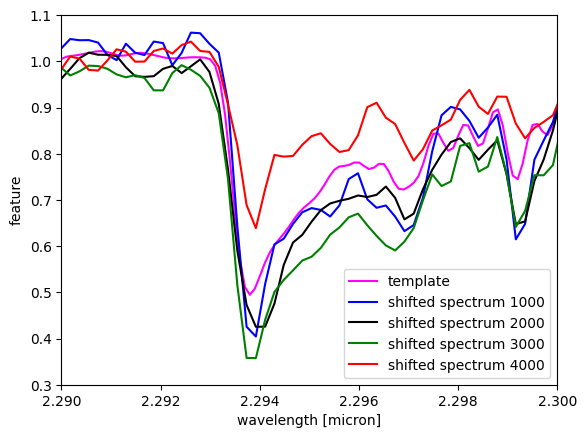

In [14]:

plt.plot(wt,templ,'-',color='magenta',label='template')
plt.plot(res[3],x_shifted[:,1000],'b-',label='shifted spectrum 1000')
plt.plot(res[3],x_shifted[:,2000],'k-',label='shifted spectrum 2000')
plt.plot(res[3],x_shifted[:,3000],'g-',label='shifted spectrum 3000')
plt.plot(res[3],x_shifted[:,4000],'r-',label='shifted spectrum 4000')
plt.legend(loc="best")
plt.ylim(0.3,1.1)
plt.xlim(2.29,2.30)
plt.xlabel("wavelength [micron]")
plt.ylabel("feature")

Text(0, 0.5, 'feature')

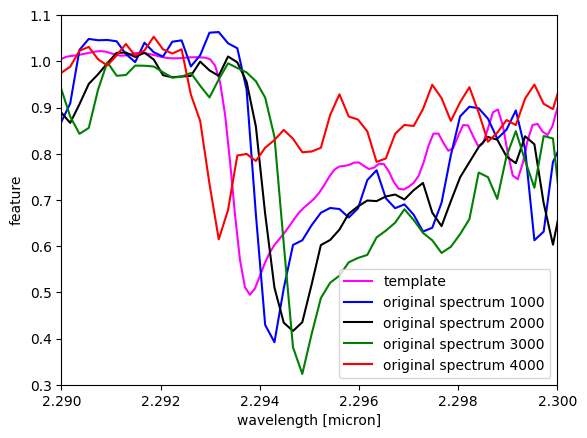

In [15]:
plt.plot(wt,templ,'-',color='magenta',label='template')
plt.plot(res[3],x[:,1000],'b-',label='original spectrum 1000')
plt.plot(res[3],x[:,2000],'k-',label='original spectrum 2000')
plt.plot(res[3],x[:,3000],'g-',label='original spectrum 3000')
plt.plot(res[3],x[:,4000],'r-',label='original spectrum 4000')
plt.legend(loc="best")
plt.ylim(0.3,1.1)
plt.xlim(2.29,2.30)
plt.xlabel("wavelength [micron]")
plt.ylabel("feature")

Look what are the most extreme velocities. They should not reach the limits.

In [16]:
print(f"maximal velocity is {max(velg2[13])}")
print(f"minimal velocity is {min(velg2[13])}")
s=np.argsort(-velg2[13])
for i in range(90):
    print(f"{i+1} largest velocity is {velg2[13,s[i]]}")

maximal velocity is 499.5
minimal velocity is -379.5
1 largest velocity is 499.5
2 largest velocity is 499.5
3 largest velocity is 499.5
4 largest velocity is 499.0
5 largest velocity is 499.0
6 largest velocity is 499.0
7 largest velocity is 499.0
8 largest velocity is 499.0
9 largest velocity is 499.0
10 largest velocity is 499.0
11 largest velocity is 499.0
12 largest velocity is 499.0
13 largest velocity is 499.0
14 largest velocity is 499.0
15 largest velocity is 499.0
16 largest velocity is 499.0
17 largest velocity is 499.0
18 largest velocity is 499.0
19 largest velocity is 499.0
20 largest velocity is 499.0
21 largest velocity is 499.0
22 largest velocity is 499.0
23 largest velocity is 499.0
24 largest velocity is 499.0
25 largest velocity is 499.0
26 largest velocity is 499.0
27 largest velocity is 499.0
28 largest velocity is 499.0
29 largest velocity is 499.0
30 largest velocity is 499.0
31 largest velocity is 499.0
32 largest velocity is 499.0
33 largest velocity is 499.0

86 velocities are at the upper limit 500 km/s. There should be no velocities there. We plot them now.

Text(0, 0.5, 'feature')

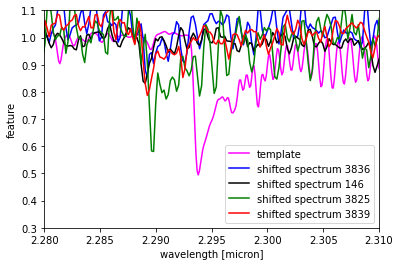

In [13]:

plt.plot(wt,templ,'-',color='magenta',label='template')
plt.plot(res[3],x_shifted[:,s[0]],'b-',label=f'shifted spectrum {s[0]}')
plt.plot(res[3],x_shifted[:,s[1]],'k-',label=f'shifted spectrum {s[1]}')
plt.plot(res[3],x_shifted[:,s[2]],'g-',label=f'shifted spectrum {s[2]}')
plt.plot(res[3],x_shifted[:,s[3]],'r-',label=f'shifted spectrum {s[3]}')
plt.legend(loc="best")
plt.ylim(0.3,1.1)
plt.xlim(2.28,2.31)
plt.xlabel("wavelength [micron]")
plt.ylabel("feature")

These are all stars with rather narrow,  also often no so deep features. Means that the template was too wrong. 

In [17]:
#Looking on which spectrum was used a lot for correlation with old code
for i in range(1,13):
    print(f"spectrum {i} was used {np.count_nonzero(calv[11] == i)} times")
#spectrum 11 was used before now we try spectrum 4
hbin=fits.open(path+'smh_hd35369_v15c.fits')
templ2=hbin[0].data
hbin.close()
print(f"template {templ2}")

spectrum 1 was used 11 times
spectrum 2 was used 14 times
spectrum 3 was used 10 times
spectrum 4 was used 49 times
spectrum 5 was used 8 times
spectrum 6 was used 27 times
spectrum 7 was used 12 times
spectrum 8 was used 12 times
spectrum 9 was used 29 times
spectrum 10 was used 24 times
spectrum 11 was used 184 times
spectrum 12 was used 41 times
template [0.9970584  1.00086    1.002802   ... 0.9910091  0.98795277 0.9916013 ]


Test the new template on some of the fastest stars. 

In [18]:
for i in range(3):
    print(f"spectrum {i}")
    rv, cc = pyasl.crosscorrRV(res[3,1383:2649], x[1383:2649,s[i]], wt, templ, -500., 500., 0.5,mode='doppler')
    rv2, cc2 = pyasl.crosscorrRV(res[3,1383:2649], x[1383:2649,s[i]], wt, templ2, -500., 500., 0.5,mode='doppler')
    print(f"template 1, best correlation of {cc[np.argmax(cc)]} at {rv[np.argmax(cc)]} km/s")
    print(f"template 2, best correlation of {cc2[np.argmax(cc2)]} at {rv2[np.argmax(cc2)]} km/s")       
    print(f" past velocity is {velg[1,s[i]]} km/s")
#works thus use it for all

spectrum 0
template 1, best correlation of 1169.9171786459508 at 499.5 km/s
template 2, best correlation of 1253.65437643759 at -80.0 km/s
 past velocity is -81.5 km/s
spectrum 1
template 1, best correlation of 1146.406265627579 at 499.5 km/s
template 2, best correlation of 1225.8455784197167 at -114.0 km/s
 past velocity is -112.0 km/s
spectrum 2
template 1, best correlation of 1130.018883930795 at 499.5 km/s
template 2, best correlation of 1208.4509471770407 at -19.5 km/s
 past velocity is -22.0 km/s


The template 2 gets velocities which are not at the limits and which consistent with the past correlation velocity. Now we use both tremplate and use the one with the with higher maximum correlation. 

In [19]:
#x2_shifted=np.zeros((np.shape(x)[0],np.shape(x)[1]))
#velg3=np.zeros((np.shape(velg)[0]+3,np.shape(velg)[1]))
#velg3[0:12,:]=velg
#for i in range(np.shape(velg3)[1]):
#    print(f"spectrum {i}")
#    rv, cc = pyasl.crosscorrRV(res[3,1383:2649], x[1383:2649,i], wt, templ, -500., 500., 0.5,mode='doppler')
#    rv2, cc2 = pyasl.crosscorrRV(res[3,1383:2649], x[1383:2649,i], wt, templ2, -500., 500., 0.5,mode='doppler')
#    print(f"template 1, best correlation of {cc[np.argmax(cc)]} at {rv[np.argmax(cc)]} km/s")
#    print(f"template 2, best correlation of {cc2[np.argmax(cc2)]} at {rv2[np.argmax(cc2)]} km/s") 
#    ar=np.zeros((2,2))
#    ar[0,0]=cc[np.argmax(cc)]
#    ar[1,0]=rv[np.argmax(cc)]
#    ar[0,1]=cc2[np.argmax(cc2)]
#    ar[1,1]=rv2[np.argmax(cc2)]    
#    velg3[12,i]=max(ar[0,:])
#    velg3[13,i]=ar[np.argmax(ar[0,:]),1]
#    velg3[14,i]=np.argmax(ar[0,:])
#    print(f"optained values are {velg3[12:15,i]}")
#    print(f" past velocity is {velg[1,i]} km/s")
#    nflux, wlprime1=pyasl.dopplerShift(res[3],x[:,i],-velg3[13,i],edgeHandling='fillValue',fillValue=0)
#    x2_shifted[:,i]=nflux
#gain it is large and thus saved and loaded again 
#np.savetxt('velocities_pyas_2templ_sn40.txt', velg3)
#np.savetxt('shifted_spectra_2templ_pyas_sn40.txt', x2_shifted)
#takes time such is svaed and loaded
velg3=np.loadtxt(path+"velocities_pyas_2templ_sn40.txt")
x2_shifted=np.loadtxt(path+"shifted_spectra_2templ_pyas_sn40.txt")

We check again for the largest and smallest velocity and then compare with the past velocities. 

maximal velocity is 410.5
minimal velocity is -369.0


Text(0, 0.5, 'Python [km/s]')

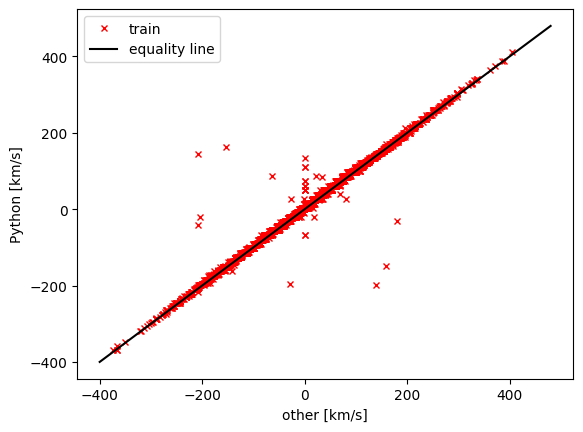

In [20]:
print(f"maximal velocity is {max(velg3[13])}")
print(f"minimal velocity is {min(velg3[13])}")
ar=[-400,480]
plt.plot(velg3[1],velg3[13],'rx',ms=4,label='train')
plt.plot(ar[0:2],ar[0:2],'-',color='black',label='equality line')
plt.legend(loc="best")
plt.xlabel("other [km/s]")
plt.ylabel("Python [km/s]")

No velocities are at the limits now. Some are different compared to previous velocities. That should be the case since some previous were bad or not measured (set to 0).
Now we are looking on the shifted spectra with the largest difference between the python and the other velocities. 

1 largest velocity difference is 354.5
2 largest velocity difference is 337.5
3 largest velocity difference is 316.0
4 largest velocity difference is 306.5
5 largest velocity difference is 211.5
6 largest velocity difference is 182.5
7 largest velocity difference is 168.0
8 largest velocity difference is 164.71062
9 largest velocity difference is 150.0
10 largest velocity difference is 133.0
11 largest velocity difference is 109.5
12 largest velocity difference is 109.5
13 largest velocity difference is 73.5
14 largest velocity difference is 73.5
15 largest velocity difference is 67.5
16 largest velocity difference is 67.5
17 largest velocity difference is 64.0
18 largest velocity difference is 61.5
19 largest velocity difference is 61.0
20 largest velocity difference is 54.5
21 largest velocity difference is 53.5
22 largest velocity difference is 52.0
23 largest velocity difference is 50.0
24 largest velocity difference is 50.0
25 largest velocity difference is 49.5
26 largest velocit

Text(0, 0.5, 'feature')

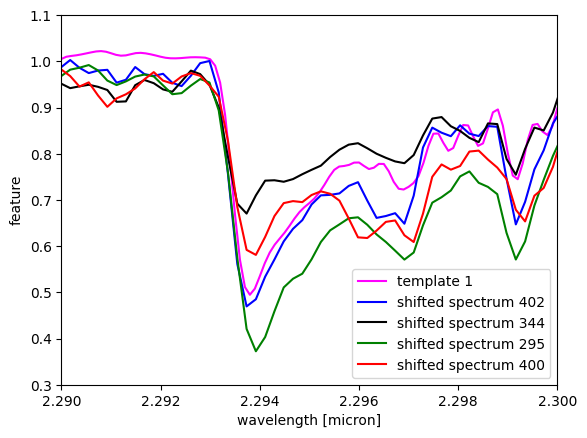

In [21]:
s=np.argsort(-abs(velg3[13]-velg3[1]))
for i in range(30):
    print(f"{i+1} largest velocity difference is {abs(velg3[13,s[i]]-velg3[1,s[i]])}")

plt.plot(wt,templ,'-',color='magenta',label='template 1')
plt.plot(res[3],x2_shifted[:,s[0]],'b-',label=f'shifted spectrum {s[0]}')
plt.plot(res[3],x2_shifted[:,s[1]],'k-',label=f'shifted spectrum {s[1]}')
plt.plot(res[3],x2_shifted[:,s[2]],'g-',label=f'shifted spectrum {s[2]}')
plt.plot(res[3],x2_shifted[:,s[3]],'r-',label=f'shifted spectrum {s[3]}')
plt.legend(loc="best")
plt.ylim(0.3,1.1)
plt.xlim(2.29,2.30)
plt.xlabel("wavelength [micron]")
plt.ylabel("feature")

The shifted spectra agry with template now. Thus the new velocities are better. As the next step getting we are getting summary statistics for the shifted spectra. 

In [22]:
res2=np.zeros((10,3072))
#gets extreme lower and upper border of data range, excluding featurres which are something 0 because of no data
lowb=0
highb=0
for i in range(3072):
    res2[0,i]=i
    res2[1,i]= np.count_nonzero(x2_shifted[i]==0)/cg #number of zeros 
    res2[3,i]=1.92499995231628+i* 0.000187174489838071  #wavelength in micron 
    res2[2,i]=np.mean(x2_shifted[i])
    res2[4,i]=np.median(x2_shifted[i])  
    res2[5,i]=np.quantile(x2_shifted[i],0.05)    
    res2[6,i]=np.quantile(x2_shifted[i],0.25)  
    res2[7,i]=np.quantile(x2_shifted[i],0.75)  
    res2[8,i]=np.quantile(x2_shifted[i],0.95)  
    if res2[1,i]==0:
       highb=i
       if lowb==0:
            lowb=i 
print(f"data features are maybe good from {lowb} to {highb}")
print("This is case a")
#this selection could be too inclusive
xsel=x2_shifted[lowb:highb]
#wavelength and original feature number information
ressel=res2[:,lowb:highb]
resselold=res[:,lowb:highb]
#other selection is between 2.08 and 2.304 that is somewhat larger than 2.29 to have some of the feature at 2.295 still included
lowc=np.argmin(abs(res2[3]-2.08))
highc=np.argmin(abs(res2[3]-2.304))
print(f"data features are good from {lowc} to {highc}") 
print("This is case b")
xsel2=x2_shifted[lowc:highc]
ressel2=res2[:,lowc:highc]
resselold2=res[:,lowc:highc]

data features are maybe good from 150 to 2940
This is case a
data features are good from 828 to 2025
This is case b


Text(0.5, 1.0, 'all velocity shifted')

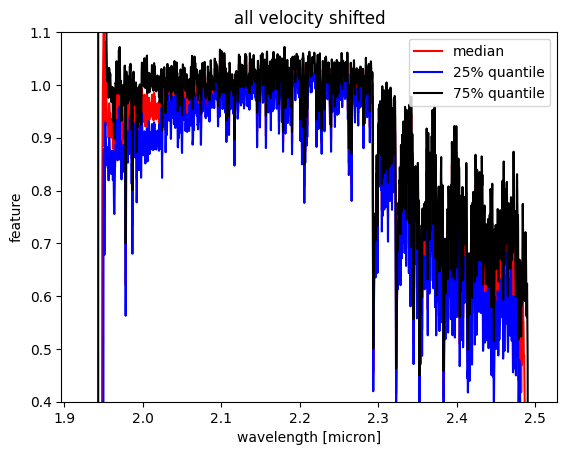

In [23]:
plt.plot(res2[3],res2[4],'r-',label='median')
plt.plot(res2[3],res2[6],'b-',label='25% quantile')
plt.plot(res2[3],res2[7],'k-',label='75% quantile')
plt.legend(loc="best")
plt.ylim(0.4,1.1)
plt.xlabel("wavelength [micron]")
plt.ylabel("feature")
plt.title("all velocity shifted")


Text(0, 0.5, 'feature')

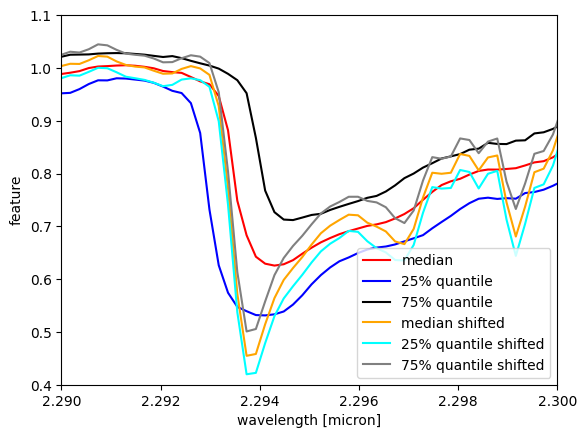

In [24]:
plt.plot(res[3],res[4],'r-',label='median')
plt.plot(res[3],res[6],'b-',label='25% quantile')
plt.plot(res[3],res[7],'k-',label='75% quantile')
plt.plot(res2[3],res2[4],'-',color='orange',label='median shifted')
plt.plot(res2[3],res2[6],'-',color='cyan',label='25% quantile shifted')
plt.plot(res2[3],res2[7],'-',color='gray',label='75% quantile shifted')
plt.legend(loc="best")
plt.ylim(0.4,1.1)
plt.xlim(2.29,2.30)
plt.xlabel("wavelength [micron]")
plt.ylabel("feature")

Now the features are narrower as they should be. As the next step we look on the difference between 25% and 75% to be less distracted by the changing baseline level.

(0.025, 1)

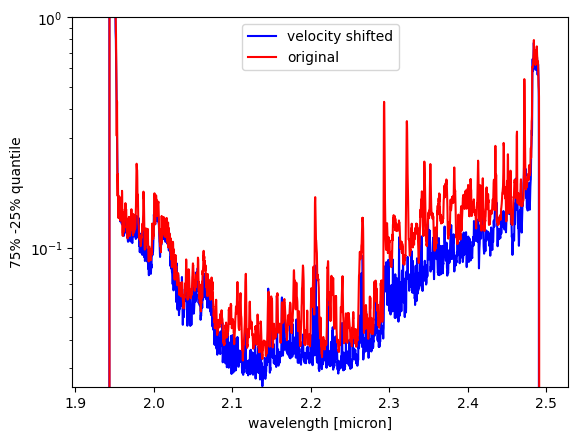

In [25]:
plt.plot(res2[3],res2[7]-res2[6]+0.0000001,'b-',label='velocity shifted')
plt.plot(res2[3],res[7]-res[6]+0.0000001,'r-',label='original')
plt.legend(loc="best")
plt.xlabel("wavelength [micron]")
plt.ylabel("75% -25% quantile")
plt.yscale('log')
plt.ylim(0.025,1)


Text(0.5, 1.0, 'selected data range case a')

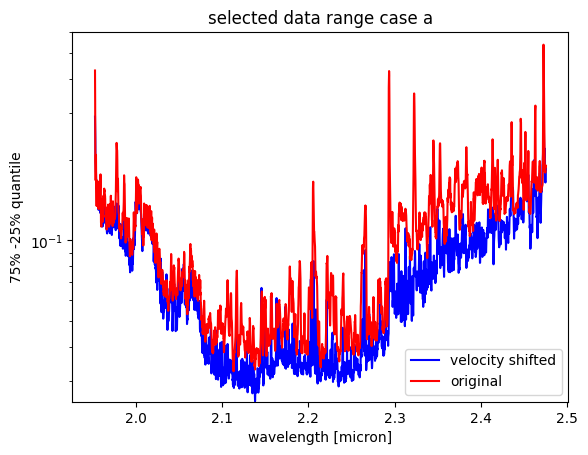

In [26]:
plt.plot(ressel[3],ressel[7]-ressel[6]+0.0000001,'b-',label='velocity shifted')
plt.plot(ressel[3],resselold[7]-resselold[6]+0.0000001,'r-',label='original')
plt.legend(loc="best")
plt.xlabel("wavelength [micron]")
plt.ylabel("75% -25% quantile")
plt.yscale('log')
plt.ylim(0.025,0.6)
plt.title("selected data range case a")

Text(0.5, 1.0, 'selected data range case b')

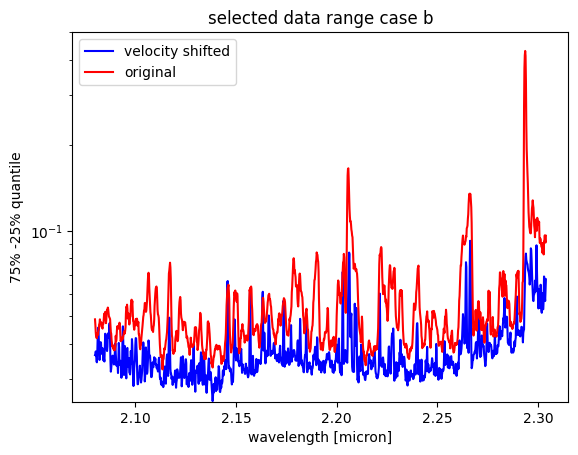

In [27]:
plt.plot(ressel2[3],ressel2[7]-ressel2[6]+0.0000001,'b-',label='velocity shifted')
plt.plot(ressel2[3],resselold2[7]-resselold2[6]+0.0000001,'r-',label='original')
plt.legend(loc="best")
plt.xlabel("wavelength [micron]")
plt.ylabel("75% -25% quantile")
plt.yscale('log')
plt.ylim(0.025,0.5)
plt.title("selected data range case b")

Text(0.5, 1.0, 'selected data range case b')

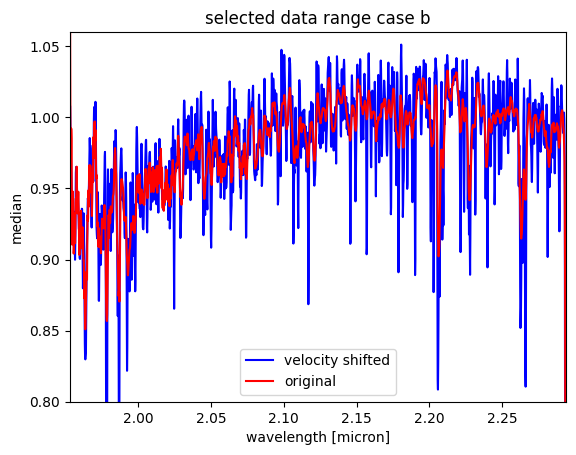

In [28]:
plt.plot(ressel[3],ressel[4],'b-',label='velocity shifted')
plt.plot(ressel[3],resselold[4],'r-',label='original')
plt.legend(loc="best")
plt.xlabel("wavelength [micron]")
plt.ylabel("median")
#plt.yscale('log')
plt.ylim(0.8,1.06)
plt.xlim(1.953,2.294)
plt.title("selected data range case b")
#could just some value cut to define pixels used for normalization (would not consider atmosphere)
#at least quadratic needed 

After velocity shifting the featured are more narrow usually, because they are not anymore smeared out by different velocities. In the standeviation most are also narrower now, but some vanished there. There are likely narrow atmospheric (of the earth) features which are smeared out after applying the shifts. Broader atmospheric like at 2.06 micron remain. The overall U shaped of the standard deviation is caused by the fact that the original spectra are normalized with a linear function between 2.08 and 2.29. We will see whether parts far way from that usuable or not. For now we use two exteame cases. Case a including everything with data, while case b includes nearly only the data which was normalized. 

0.11541218637992831


(1.97, 2.3)

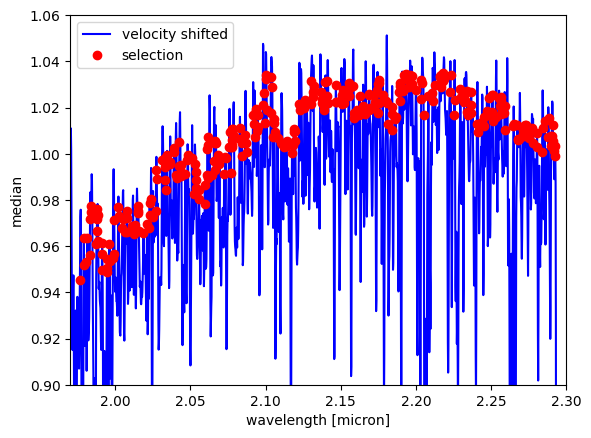

In [29]:
#selection for normlization 
#local 70 to 90 quantile exclduing problematic blue and red wavelength
ressel[9,:]=0
for i in range(30,np.shape(ressel)[1]-30):
    if ressel[3,i]<2.295 and ressel[3,i]>1.975 and ressel[4,i]>np.quantile(ressel[4,i-30:i+30],0.7) and ressel[4,i]<np.quantile(ressel[4,i-30:i+30],0.9):
        ressel[9,i]=1
    else:
        ressel[9,i]=0
print(np.mean(ressel[9]))   
plt.plot(ressel[3],ressel[4],'b-',label='velocity shifted')
plt.plot(ressel[3],ressel[9]*ressel[4],'ro',label='selection')
plt.legend(loc="best")
plt.xlabel("wavelength [micron]")
plt.ylabel("median")
#plt.yscale('log')
plt.ylim(0.9,1.06)
plt.xlim(1.97,2.30)


In [30]:
#linear regression first on the data above used for selection
regr =LinearRegression()
lima=1.9
limb=2.5
poly=1
print(f"degree is {poly}")
c=0
ar=np.zeros((int(poly+1),3072))
for i in range(np.shape(ressel)[1]):
    if ressel[9,i]==1 and ressel[3,i]>lima and ressel[4,i]<limb:
        ar[0,c]=ressel[4,i]
        for j in range(poly):
            ar[j+1,c]=ressel[3,i]**(j+1)
        c+=1
ar=ar[:,0:c]
regr.fit(ar[1:int(1+poly),:].T,ar[0,:])
print("Coefficients are : \n", regr.coef_)
pred = regr.predict(ar[1:int(1+poly),:].T)
print(f"standard deviation is {np.std(ar[0,:]-pred)}")

poly=2
print(f"degree is {poly}")
c=0
ar=np.zeros((int(poly+1),3072))
for i in range(np.shape(ressel)[1]):
    if ressel[9,i]==1 and ressel[3,i]>lima and ressel[4,i]<limb:
        ar[0,c]=ressel[4,i]
        for j in range(poly):
            ar[j+1,c]=ressel[3,i]**(j+1)
        c+=1
ar=ar[:,0:c]
regr.fit(ar[1:int(1+poly),:].T,ar[0,:])
print("Coefficients are : \n", regr.coef_)
pred = regr.predict(ar[1:int(1+poly),:].T)
print(f"standard deviation is {np.std(ar[0,:]-pred)}")

poly=3
print(f"degree is {poly}")
c=0
ar=np.zeros((int(poly+1),3072))
for i in range(np.shape(ressel)[1]):
    if ressel[9,i]==1 and ressel[3,i]>lima and ressel[4,i]<limb:
        ar[0,c]=ressel[4,i]
        for j in range(poly):
            ar[j+1,c]=ressel[3,i]**(j+1)
        c+=1
ar=ar[:,0:c]
regr.fit(ar[1:int(1+poly),:].T,ar[0,:])
print("Coefficients are : \n", regr.coef_)
pred = regr.predict(ar[1:int(1+poly),:].T)
print(f"standard deviation is {np.std(ar[0,:]-pred)}")

poly=4
print(f"degree is {poly}")
c=0
ar=np.zeros((int(poly+1),3072))
for i in range(np.shape(ressel)[1]):
    if ressel[9,i]==1 and ressel[3,i]>lima and ressel[4,i]<limb:
        ar[0,c]=ressel[4,i]
        for j in range(poly):
            ar[j+1,c]=ressel[3,i]**(j+1)
        c+=1
ar=ar[:,0:c]
regr.fit(ar[1:int(1+poly),:].T,ar[0,:])
print("Coefficients are : \n", regr.coef_)
pred = regr.predict(ar[1:int(1+poly),:].T)
print(f"standard deviation is {np.std(ar[0,:]-pred)}")


poly=5
print(f"degree is {poly}")
c=0
ar=np.zeros((int(poly+1),3072))
for i in range(np.shape(ressel)[1]):
    if ressel[9,i]==1 and ressel[3,i]>lima and ressel[4,i]<limb:
        ar[0,c]=ressel[4,i]
        for j in range(poly):
            ar[j+1,c]=ressel[3,i]**(j+1)
        c+=1
ar=ar[:,0:c]
regr.fit(ar[1:int(1+poly),:].T,ar[0,:])
print("Coefficients are : \n", regr.coef_)
pred = regr.predict(ar[1:int(1+poly),:].T)
print(f"standard deviation is {np.std(ar[0,:]-pred)}")

degree is 1
Coefficients are : 
 [0.168229]
standard deviation is 0.014752481087201692
degree is 2
Coefficients are : 
 [ 7.22680537 -1.65250364]
standard deviation is 0.0074601748417892026
degree is 3
Coefficients are : 
 [-21.69876264  11.90879842  -2.11693816]
standard deviation is 0.007342800496494462
degree is 4
Coefficients are : 
 [-23.63145182  13.26867889  -2.54185785   0.04975019]
standard deviation is 0.007342800094655531
degree is 5
Coefficients are : 
 [-8971.73720213  8406.77554873 -3936.74521668   921.49923609
   -86.27363718]
standard deviation is 0.00733485927560914


It seems that second degree is the needed for the mean. However, we remain flexible for run, since it could be different for the single star spectra. 

Below we define a function for normalization

In [31]:
#define the function 
#arguments: spectruum to be normalized, wavelength of it, good pixel (all of same corresponding length)
#lower and upper limit used, polynom degree
def norm(spec,wave, select, lima, limb, poly):
    c=0
    ar=np.zeros((int(poly+1),np.shape(spec)[0])) #for fitting
    ar2=np.zeros((int(poly+1),np.shape(spec)[0])) #for applying
    for i in range(np.shape(spec)[0]):
        for j in range(poly):
            ar2[j+1,i]=(wave[i]-(lima+limb)/2)**(j+1)        
            if select[i]==1 and wave[i]>lima and wave[i]<limb:
                ar[0,c]=spec[i]
                for j in range(poly):
                    ar[j+1,c]=(wave[i]-(lima+limb)/2)**(j+1)
                c+=1
    ar=ar[:,0:c]
    regr.fit(ar[1:int(1+poly),:].T,ar[0,:])
    pred = regr.predict(ar[1:int(1+poly),:].T)
    pred2 = regr.predict(ar2[1:int(1+poly),:].T) 
    std=np.std(ar[0,:]-pred)
    coef=np.zeros((int(poly+1)))
    coef[0]=regr.intercept_
    coef[1:int(poly+1)]=regr.coef_
    norm=spec/pred2
    return norm, coef, std

standardeviation is 0.007460174841789197
parameters are [ 1.02460391 -0.04421067 -1.65250364]


(1.95, 2.3)

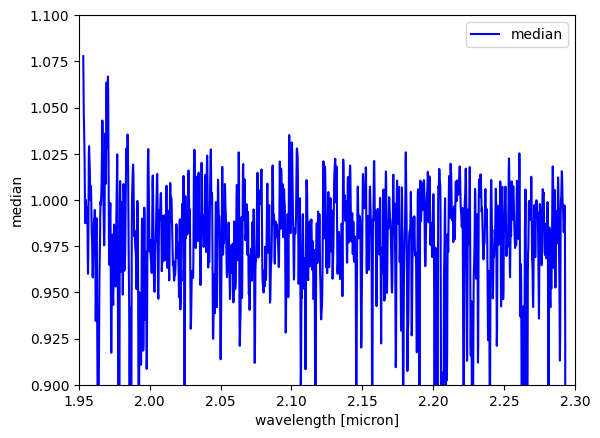

In [32]:
normsa,n,coef=norm(ressel[4],ressel[3],ressel[9],1.9,2.5,int(2))
print(f"standardeviation is {coef}")
print(f"parameters are {n}")
plt.plot(ressel[3],normsa,'b-',label='median')
#plt.plot(ressel[3],ressel[9]*ressel[4],'ro',label='selection')
plt.legend(loc="best")
plt.xlabel("wavelength [micron]")
plt.ylabel("median")
#plt.yscale('log')
plt.ylim(0.9,1.1)
plt.xlim(1.95,2.30)

standard deviation is 0.041163502608500796
parameters are [ 0.99531927 -1.12120796 -5.52435801]


(1.95, 2.3)

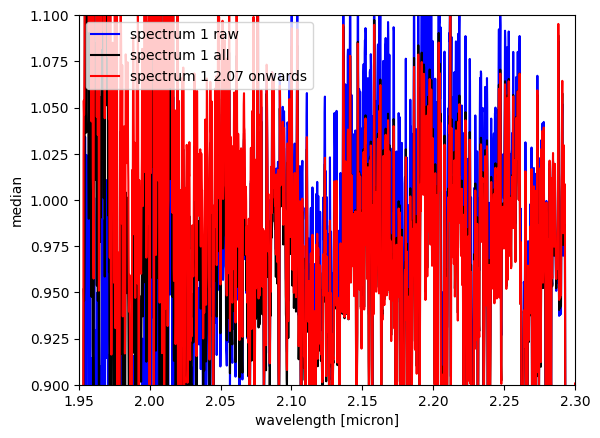

In [34]:
norms,n,coef=norm(xsel[:,1],ressel[3],ressel[9],2.07,2.5,int(2))
norms2,n2,coef2=norm(xsel[:,1],ressel[3],ressel[9],1.95,2.5,int(2))
print(f"standard deviation is {coef}")
print(f"parameters are {n}")
plt.plot(ressel[3],xsel[:,1],'b-',label='spectrum 1 raw')
plt.plot(ressel[3],norms2,'k-',label='spectrum 1 all')
plt.plot(ressel[3],norms,'r-',label='spectrum 1 2.07 onwards')
#plt.plot(ressel[3],ressel[9]*ressel[4],'ro',label='selection')
plt.legend(loc="best")
plt.xlabel("wavelength [micron]")
plt.ylabel("median")
#plt.yscale('log')
plt.ylim(0.9,1.1)
plt.xlim(1.95,2.30)

In [35]:
#Now apply to all
xseln=np.zeros((np.shape(xsel)[0],np.shape(xsel)[1]))
coefs=np.zeros((4,np.shape(xsel)[1]))
for i in range(np.shape(xsel)[1]):
    print(i)
    norms,coef,n=norm(xsel[:,i],ressel[3],ressel[9],2.07,2.5,int(2))
    xseln[:,i]=norms
    coefs[0:3,i]=coef
    coefs[3,i]=n

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067


3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716


(0.025, 1)

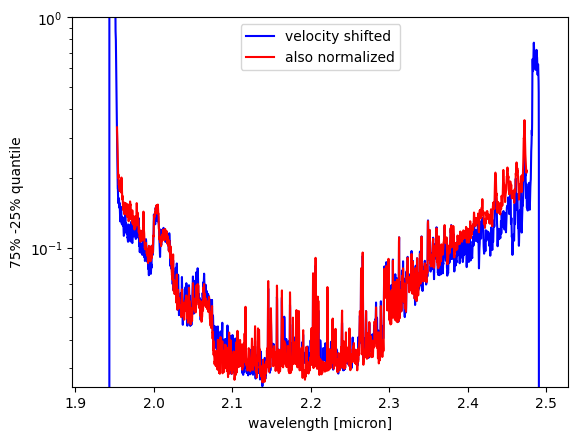

In [36]:
#the usual statistic 
resn=np.zeros((10,2790))
#gets extreme lower and upper border of data range, excluding featurres which are something 0 because of no data
lowb=0
highb=0
resn[0]=ressel[0]
resn[3]=ressel[3]
for i in range(2790):
    resn[1,i]= np.count_nonzero(xseln[i]==0)/cg #number of zeros 
    resn[2,i]=np.mean(xseln[i])
    resn[4,i]=np.median(xseln[i])  
    resn[5,i]=np.quantile(xseln[i],0.05)    
    resn[6,i]=np.quantile(xseln[i],0.25)  
    resn[7,i]=np.quantile(xseln[i],0.75)  
    resn[8,i]=np.quantile(xseln[i],0.95)
plt.plot(res2[3],res2[7]-res2[6]+0.0000001,'b-',label='velocity shifted')
plt.plot(resn[3],resn[7]-resn[6]+0.0000001,'r-',label='also normalized')
plt.legend(loc="best")
plt.xlabel("wavelength [micron]")
plt.ylabel("75% -25% quantile")
plt.yscale('log')
plt.ylim(0.025,1)    

(0.025, 0.1)

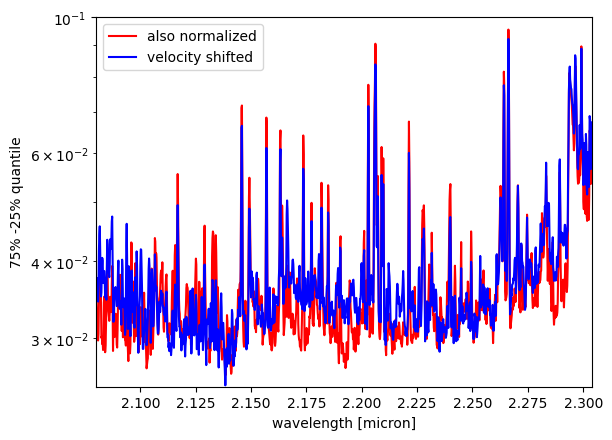

In [39]:
plt.plot(resn[3],resn[7]-resn[6]+0.0000001,'r-',label='also normalized')
plt.plot(res2[3],res2[7]-res2[6]+0.0000001,'b-',label='velocity shifted')
plt.legend(loc="best")
plt.xlabel("wavelength [micron]")
plt.ylabel("75% -25% quantile")
plt.yscale('log')
plt.xlim(2.08,2.304)
plt.ylim(0.025,0.1)  
#usually better although less clear around 2.17 which was in the middle before, still lines are prominent there

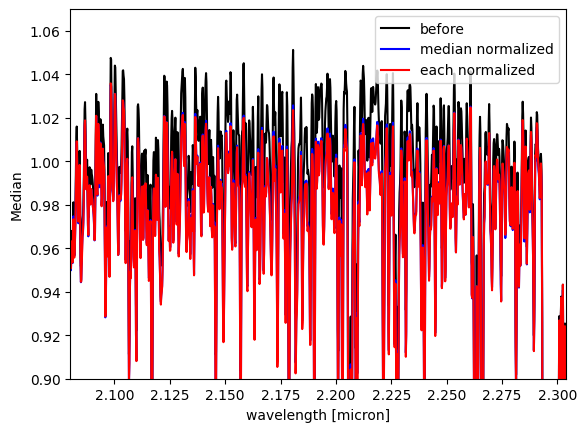

In [40]:
plt.plot(res2[3],res2[4],'k-',label='before')
plt.plot(ressel[3],normsa,'b-',label='median normalized')
plt.plot(resn[3],resn[4],'r-',label='each normalized')
plt.legend(loc="best")
plt.xlabel("wavelength [micron]")
plt.ylabel("Median")
plt.xlim(2.08,2.304)
#plt.yscale('log')
plt.ylim(0.9,1.07)  
#select nprmal wavelngth window
lowc=np.argmin(abs(resn[3]-2.08))
highc=np.argmin(abs(resn[3]-2.304))
xselnb=xseln[lowc:highc]

Now we apply PCA.

In [42]:
#print(np.shape(xsel2))
pca = PCA(n_components=1000)
print(f"shape of input {np.shape(xsel)}")
#fit
pca.fit(xsel.T)
#apply
xsel_transformed = pca.transform(xsel.T)
para1=pca.get_params(deep=True)
pca2 = PCA(n_components=1000)
pca2.fit(xsel2.T)
para2=pca2.get_params(deep=True)
xsel2_transformed = pca2.transform(xsel2.T)
print(f"shape of transformed data {np.shape(xsel_transformed)}")
np.savetxt(path+'pca_caseb_v1.txt', pca2.components_)
callin=np.loadtxt(path+"calibrator_spectra_caseb_linear.txt")
callin_trans= pca2.transform(callin.T)

shape of input (2790, 4032)
shape of transformed data (4032, 1000)


case A explained in total 0.9998587052671715
case B explained in total 0.9989525725737666


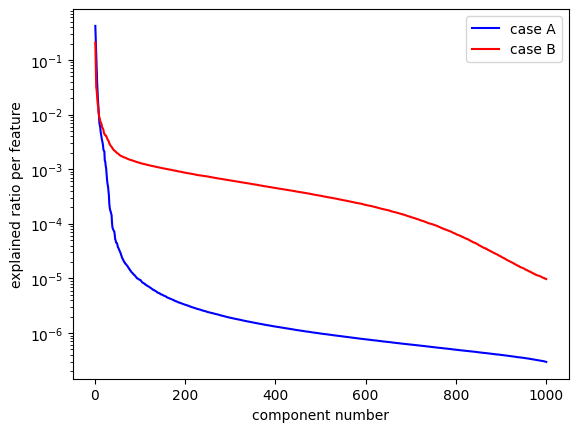

In [43]:
feat=np.arange(1,1001,1)
#get cumulative explained portion
cum=np.zeros((4,1000))
cum[0]=feat
for i in range(1000):
    cum[1,i]=np.sum(pca.explained_variance_ratio_[0:i+1])
    cum[2,i]=np.sum(pca2.explained_variance_ratio_[0:i+1])                    
print(f"case A explained in total {np.sum(pca.explained_variance_ratio_)}")
print(f"case B explained in total {np.sum(pca2.explained_variance_ratio_)}")
plt.plot(feat,pca.explained_variance_ratio_,'b-',label='case A')
plt.plot(feat,pca2.explained_variance_ratio_,'r-',label='case B')
plt.legend(loc="best")
plt.xlabel("component number")
plt.ylabel("explained ratio per feature")
plt.yscale("log")
np.savetxt(path+'norm_mask_v1.txt', ressel)

explained in first 10 cumulative in case A [0.42011137 0.64622661 0.76865995 0.83259837 0.87211132 0.89881075
 0.91672828 0.93019633 0.94004514 0.94698803]
explained in first 10 cumulative in case B [0.2093702  0.29956373 0.33157645 0.35888824 0.37975601 0.39632747
 0.41064297 0.42160048 0.43151913 0.44027194]


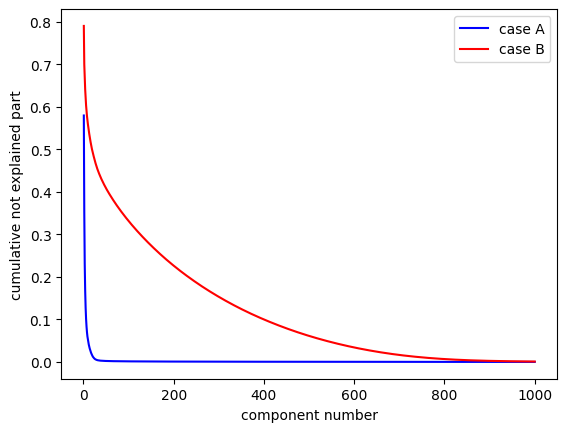

In [44]:
plt.plot(feat,1-cum[1],'b-',label='case A')
plt.plot(feat,1-cum[2],'r-',label='case B')
plt.legend(loc="best")
plt.xlabel("component number")
plt.ylabel("cumulative not explained part")
print(f"explained in first 10 cumulative in case A {cum[1,0:10]}")
print(f"explained in first 10 cumulative in case B {cum[2,0:10]}")

A bigger part is explained with few features for the more inclusive case A. However, that does not mean that this is better because those features contain more 'noise' because of normalization extrapolation and more atmspheric features there. It is also visible that for case B it takes a big number of features to explain nearly everything. A part of that can be caused by intrinsic noise. Now we looking on weights obtained for the first view components.

Text(0.5, 1.0, 'selected data range case a')

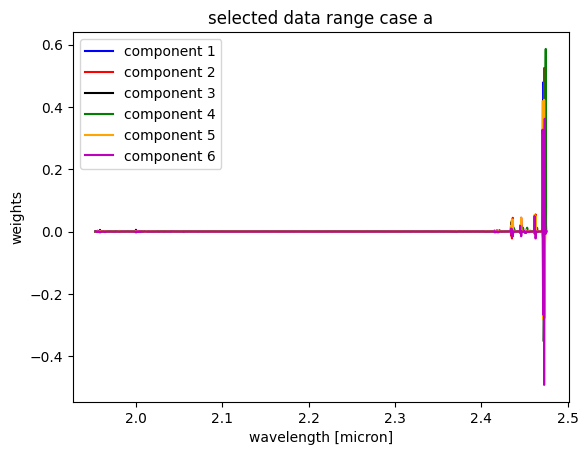

In [45]:
plt.plot(ressel[3],(pca.components_[0]),'b-',label='component 1')
plt.plot(ressel[3],(pca.components_[1]),'r-',label='component 2')
plt.plot(ressel[3],(pca.components_[2]),'k-',label='component 3')
plt.plot(ressel[3],(pca.components_[3]),'g-',label='component 4')
plt.plot(ressel[3],(pca.components_[4]),'-',color='orange',label='component 5')
plt.plot(ressel[3],(pca.components_[5]),'m-',label='component 6')
plt.legend(loc="best")
plt.xlabel("wavelength [micron]")
plt.ylabel("weights")
#plt.yscale('log')
#plt.ylim(0.025,0.6)
plt.title("selected data range case a")

Text(0.5, 1.0, 'selected data range case a')

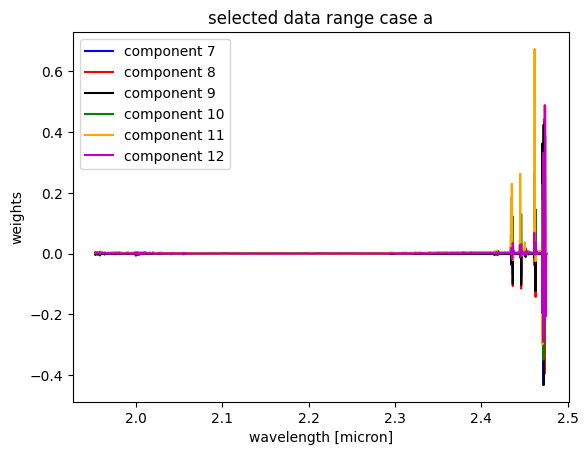

In [46]:
plt.plot(ressel[3],(pca.components_[6]),'b-',label='component 7')
plt.plot(ressel[3],(pca.components_[7]),'r-',label='component 8')
plt.plot(ressel[3],(pca.components_[8]),'k-',label='component 9')
plt.plot(ressel[3],(pca.components_[9]),'g-',label='component 10')
plt.plot(ressel[3],(pca.components_[10]),'-',color='orange',label='component 11')
plt.plot(ressel[3],(pca.components_[11]),'m-',label='component 12')
plt.legend(loc="best")
plt.xlabel("wavelength [micron]")
plt.ylabel("weights")
#plt.yscale('log')
#plt.ylim(0.025,0.6)
plt.title("selected data range case a")

In the first at least 12 components in case A, most of the weight is in rather rather range at wavelength larger than 2.4 micron. There are artifacts there partly caused by the atmosphre. Because they are strong they are no averaged out and many compoenent are needed because after the shifting they are not at the same wavelengths. Thus the first components are not useful in case A. That makes use of case A more difficult in general. 

Now we look on case B.

Text(0.5, 1.0, 'selected data range case b')

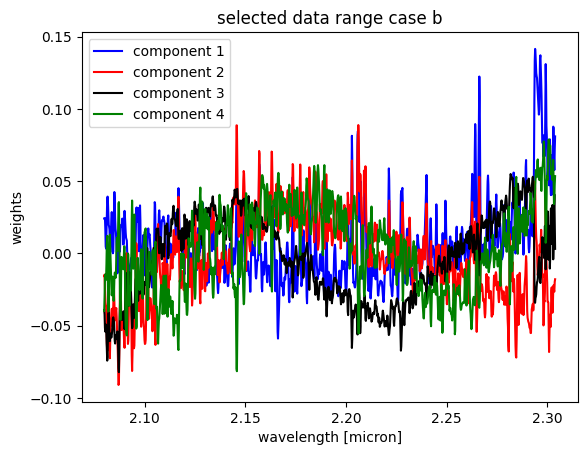

In [47]:
plt.plot(ressel2[3],(pca2.components_[0]),'b-',label='component 1')
plt.plot(ressel2[3],(pca2.components_[1]),'r-',label='component 2')
plt.plot(ressel2[3],(pca2.components_[2]),'k-',label='component 3')
plt.plot(ressel2[3],(pca2.components_[3]),'g-',label='component 4')
plt.legend(loc="best")
plt.xlabel("wavelength [micron]")
plt.ylabel("weights")
#plt.yscale('log')
#plt.ylim(0.025,0.6)
plt.title("selected data range case b")

Text(0.5, 1.0, 'selected data range case b')

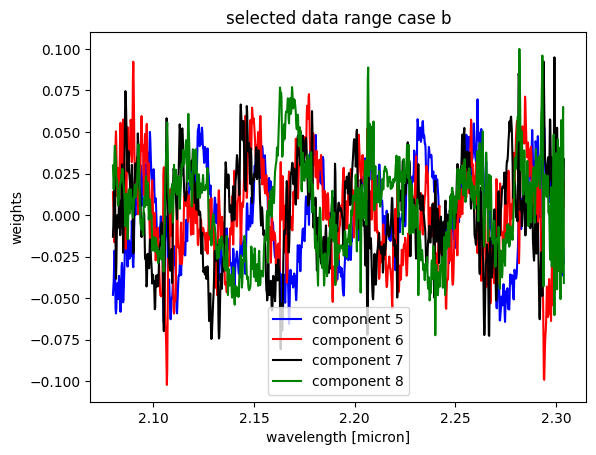

In [48]:
plt.plot(ressel2[3],(pca2.components_[4]),'b-',label='component 5')
plt.plot(ressel2[3],(pca2.components_[5]),'r-',label='component 6')
plt.plot(ressel2[3],(pca2.components_[6]),'k-',label='component 7')
plt.plot(ressel2[3],(pca2.components_[7]),'g-',label='component 8')
plt.legend(loc="best")
plt.xlabel("wavelength [micron]")
plt.ylabel("weights")
#plt.yscale('log')
#plt.ylim(0.025,0.6)
plt.title("selected data range case b")

Text(0.5, 1.0, 'selected data range case b')

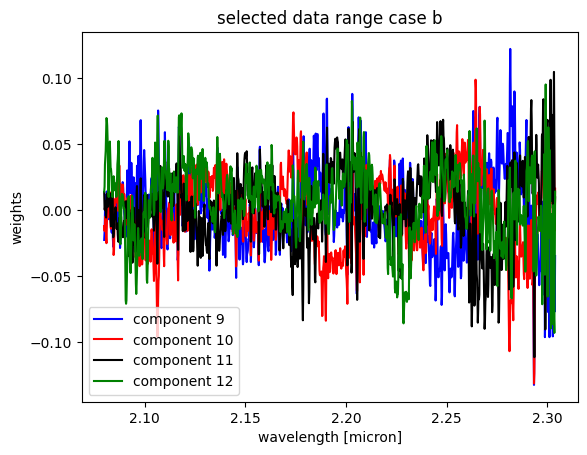

In [49]:
plt.plot(ressel2[3],(pca2.components_[8]),'b-',label='component 9')
plt.plot(ressel2[3],(pca2.components_[9]),'r-',label='component 10')
plt.plot(ressel2[3],(pca2.components_[10]),'k-',label='component 11')
plt.plot(ressel2[3],(pca2.components_[11]),'g-',label='component 12')
plt.legend(loc="best")
plt.xlabel("wavelength [micron]")
plt.ylabel("weights")
#plt.yscale('log')
#plt.ylim(0.025,0.6)
plt.title("selected data range case b")

In contrast in case B, the largest weights of compoenent 1 are at the main spectral features. That is also partly case down to componnent 3 and maybe 4, although for larger numbers trends with wavelength get stronger. These trends are caused by the not prefect normalization. For component 5 to at least 12 the main signal is a wave of about 0.03 micron period. That is a spurious signal.   

In [50]:
#now after better normalization in case B

In [51]:

pcanb = PCA(n_components=1000)
pcanb.fit(xselnb.T)
paranb=pcanb.get_params(deep=True)
xselnb_transformed = pcanb.transform(xselnb.T)
#cal transformed is elsewhere done, not ideal? 
cal=np.loadtxt(path+"calibrator_spectra_caseb_3rdorder.txt")
cal_trans= pcanb.transform(cal.T)

case A explained in total 0.9998587052671715
case B explained in total 0.9989525725737666
case B normalized explained in total 0.9989396900564003


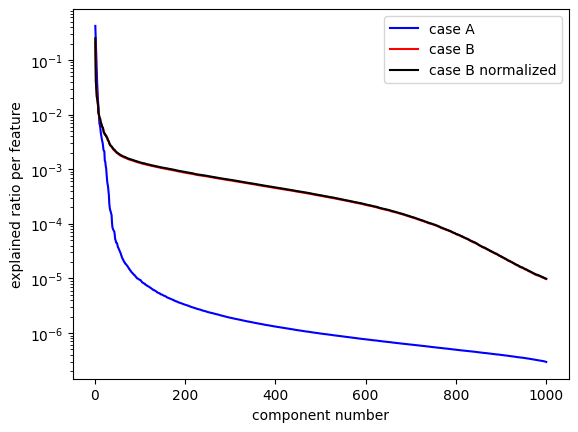

In [52]:
for i in range(1000):
    cum[3,i]=np.sum(pcanb.explained_variance_ratio_[0:i+1])                    
print(f"case A explained in total {np.sum(pca.explained_variance_ratio_)}")
print(f"case B explained in total {np.sum(pca2.explained_variance_ratio_)}")
print(f"case B normalized explained in total {np.sum(pcanb.explained_variance_ratio_)}")
plt.plot(feat,pca.explained_variance_ratio_,'b-',label='case A')
plt.plot(feat,pca2.explained_variance_ratio_,'r-',label='case B')
plt.plot(feat,pcanb.explained_variance_ratio_,'k-',label='case B normalized')
plt.legend(loc="best")
plt.xlabel("component number")
plt.ylabel("explained ratio per feature")
plt.yscale("log")

explained in first 10 cumulative in case A [0.42011137 0.64622661 0.76865995 0.83259837 0.87211132 0.89881075
 0.91672828 0.93019633 0.94004514 0.94698803]
explained in first 10 cumulative in case B [0.2093702  0.29956373 0.33157645 0.35888824 0.37975601 0.39632747
 0.41064297 0.42160048 0.43151913 0.44027194]
explained in first 10 cumulative in case B normalized [0.25110617 0.29129535 0.32350546 0.3448732  0.36458725 0.3822801
 0.3973854  0.4078714  0.41795865 0.42702982]


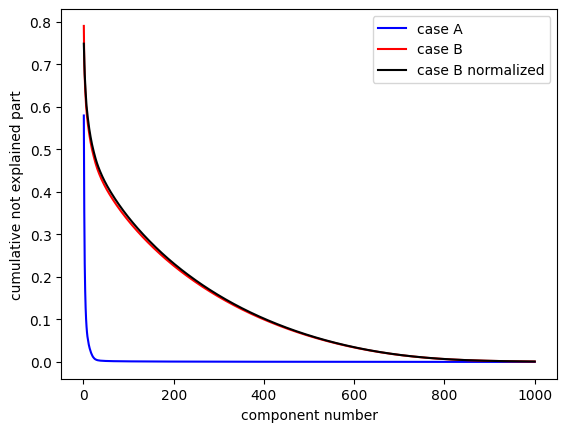

In [53]:
plt.plot(feat,1-cum[1],'b-',label='case A')
plt.plot(feat,1-cum[2],'r-',label='case B')
plt.plot(feat,1-cum[3],'k-',label='case B normalized')
plt.legend(loc="best")
plt.xlabel("component number")
plt.ylabel("cumulative not explained part")
print(f"explained in first 10 cumulative in case A {cum[1,0:10]}")
print(f"explained in first 10 cumulative in case B {cum[2,0:10]}")
print(f"explained in first 10 cumulative in case B normalized {cum[3,0:10]}")
#first is more exlained now, less then, expected, less trenbds to be explained 

Text(0.5, 1.0, 'selected data range case b normalized')

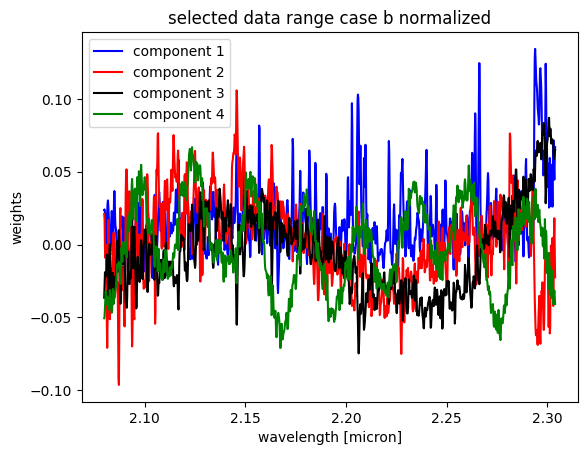

In [54]:
plt.plot(ressel2[3],(pcanb.components_[0]),'b-',label='component 1')
plt.plot(ressel2[3],(pcanb.components_[1]),'r-',label='component 2')
plt.plot(ressel2[3],(pcanb.components_[2]),'k-',label='component 3')
plt.plot(ressel2[3],(pcanb.components_[3]),'g-',label='component 4')
plt.legend(loc="best")
plt.xlabel("wavelength [micron]")
plt.ylabel("weights")
#plt.yscale('log')
#plt.ylim(0.025,0.6)
plt.title("selected data range case b normalized")

Text(0.5, 1.0, 'selected data range case b')

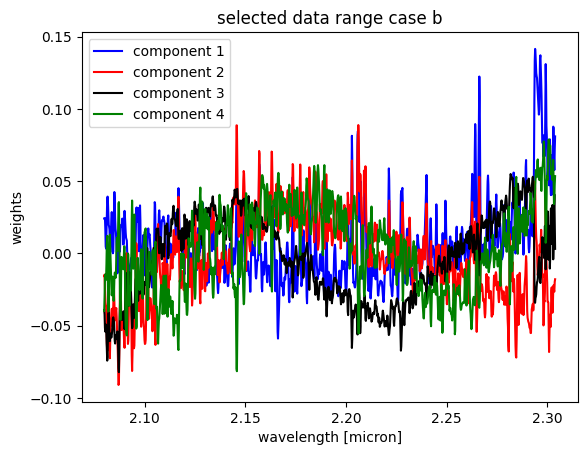

In [55]:
plt.plot(ressel2[3],(pca2.components_[0]),'b-',label='component 1')
plt.plot(ressel2[3],(pca2.components_[1]),'r-',label='component 2')
plt.plot(ressel2[3],(pca2.components_[2]),'k-',label='component 3')
plt.plot(ressel2[3],(pca2.components_[3]),'g-',label='component 4')
plt.legend(loc="best")
plt.xlabel("wavelength [micron]")
plt.ylabel("weights")
#plt.yscale('log')
#plt.ylim(0.025,0.6)
plt.title("selected data range case b")

Not so many changes. The first clear wave is moved from fourth to third component. Component 2 has less wavelength dependent trends but still more than it should. Looks like that some spectra still need higher order fits. Or is it needed to exclude the ones with waves? 


In [56]:
xseln3=np.zeros((np.shape(xsel)[0],np.shape(xsel)[1]))
coefs3=np.zeros((5,np.shape(xsel)[1]))
for i in range(np.shape(xsel)[1]):
    print(i)
    norms,coef,n=norm(xsel[:,i],ressel[3],ressel[9],2.07,2.5,int(3))
    xseln3[:,i]=norms
    coefs3[0:4,i]=coef
    coefs3[4,i]=n

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073


3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717


In [57]:
#compare stabdeviation quantile
for i in range(10):
    q=0.05+i/10
    print(f"{round(q*100)} % quantile 2nd order is {round(np.quantile(coefs[3,:],q),5)}")
    print(f"{round(q*100)} % quantile 23rd order is {round(np.quantile(coefs3[4,:],q),5)}")    

5 % quantile 2nd order is 0.01732
5 % quantile 23rd order is 0.01676
15 % quantile 2nd order is 0.01991
15 % quantile 23rd order is 0.01929
25 % quantile 2nd order is 0.02148
25 % quantile 23rd order is 0.02085
35 % quantile 2nd order is 0.02297
35 % quantile 23rd order is 0.02231
45 % quantile 2nd order is 0.02434
45 % quantile 23rd order is 0.02366
55 % quantile 2nd order is 0.02579
55 % quantile 23rd order is 0.02516
65 % quantile 2nd order is 0.02752
65 % quantile 23rd order is 0.02681
75 % quantile 2nd order is 0.02958
75 % quantile 23rd order is 0.02883
85 % quantile 2nd order is 0.03282
85 % quantile 23rd order is 0.03209
95 % quantile 2nd order is 0.0397
95 % quantile 23rd order is 0.03909


In [58]:
#some improvement not a lot, some natural with higher order 
#look on PCA
xseln3b=xseln3[lowc:highc]
pcan3b = PCA(n_components=1000)
pcan3b.fit(xseln3b.T)
paran3b=pcan3b.get_params(deep=True)
xseln3b_transformed = pcan3b.transform(xseln3b.T)
np.savetxt(path+'pca_caseb_norm3_v1.txt', pcan3b.components_)

Text(0.5, 1.0, 'selected data range case b normalized w 3rd order')

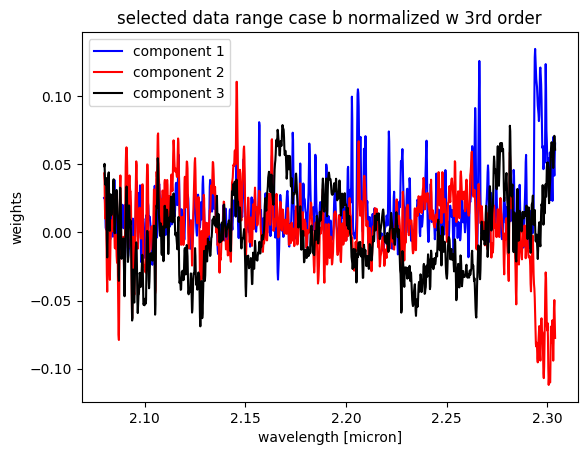

In [59]:
plt.plot(ressel2[3],(pcan3b.components_[0]),'b-',label='component 1')
plt.plot(ressel2[3],(pcan3b.components_[1]),'r-',label='component 2')
plt.plot(ressel2[3],(pcan3b.components_[2]),'k-',label='component 3')
#plt.plot(ressel2[3],(pca3b.components_[3]),'g-',label='component 4')
plt.legend(loc="best")
plt.xlabel("wavelength [micron]")
plt.ylabel("weights")
#plt.yscale('log')
#plt.ylim(0.025,0.6)
plt.title("selected data range case b normalized w 3rd order")

It is looking better now. Still something visible. Could be first hint of waves. Should look also in excluding the wave cases. Now third order contains already the first wave. 

Text(0.5, 1.0, 'selected data range case b normalized w 3rd order')

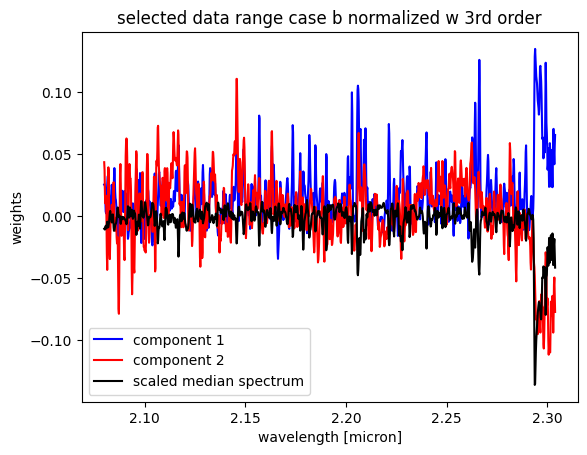

In [60]:
plt.plot(ressel2[3],(pcan3b.components_[0]),'b-',label='component 1')
plt.plot(ressel2[3],(pcan3b.components_[1]),'r-',label='component 2')
plt.plot(ressel2[3],(ressel2[4]-1)/4,'k-',label='scaled median spectrum')
plt.legend(loc="best")
plt.xlabel("wavelength [micron]")
plt.ylabel("weights")
#plt.yscale('log')
#plt.ylim(0.025,0.6)
plt.title("selected data range case b normalized w 3rd order")

Text(0.5, 1.0, 'selected data range case b normalized w 3rd order')

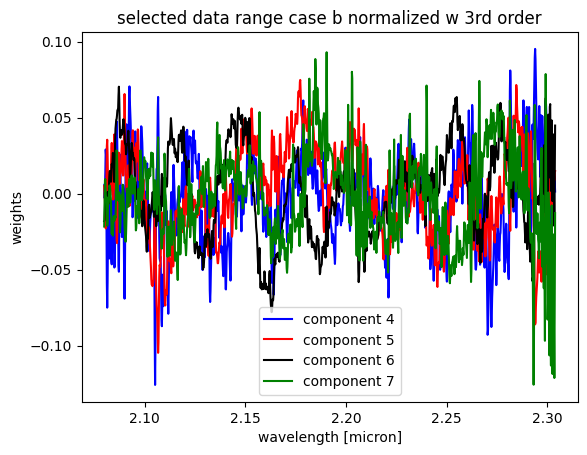

In [61]:
plt.plot(ressel2[3],(pcan3b.components_[3]),'b-',label='component 4')
plt.plot(ressel2[3],(pcan3b.components_[4]),'r-',label='component 5')
plt.plot(ressel2[3],(pcan3b.components_[5]),'k-',label='component 6')
plt.plot(ressel2[3],(pcan3b.components_[6]),'g-',label='component 7')
plt.legend(loc="best")
plt.xlabel("wavelength [micron]")
plt.ylabel("weights")
#plt.yscale('log')
#plt.ylim(0.025,0.6)
plt.title("selected data range case b normalized w 3rd order")

Text(0.5, 1.0, 'selected data range case b normalized w 3rd order')

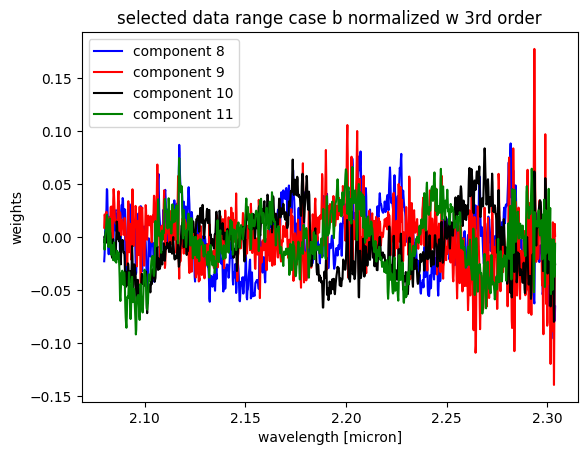

In [62]:
plt.plot(ressel2[3],(pcan3b.components_[7]),'b-',label='component 8')
plt.plot(ressel2[3],(pcan3b.components_[8]),'r-',label='component 9')
plt.plot(ressel2[3],(pcan3b.components_[9]),'k-',label='component 10')
plt.plot(ressel2[3],(pcan3b.components_[10]),'g-',label='component 11')
plt.legend(loc="best")
plt.xlabel("wavelength [micron]")
plt.ylabel("weights")
#plt.yscale('log')
#plt.ylim(0.025,0.6)
plt.title("selected data range case b normalized w 3rd order")

Text(0.5, 1.0, 'selected data range case b normalized w 3rd order')

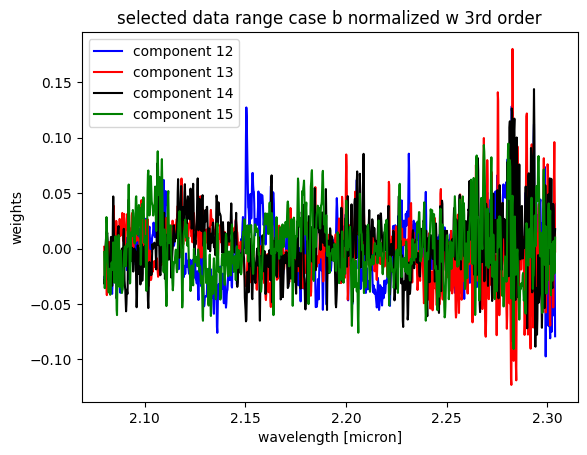

In [63]:
plt.plot(ressel2[3],(pcan3b.components_[11]),'b-',label='component 12')
plt.plot(ressel2[3],(pcan3b.components_[12]),'r-',label='component 13')
plt.plot(ressel2[3],(pcan3b.components_[13]),'k-',label='component 14')
plt.plot(ressel2[3],(pcan3b.components_[14]),'g-',label='component 15')
plt.legend(loc="best")
plt.xlabel("wavelength [micron]")
plt.ylabel("weights")
#plt.yscale('log')
#plt.ylim(0.025,0.6)
plt.title("selected data range case b normalized w 3rd order")

Seems mostly waves until component 12. Often there is some mixture.

(4032,)


Text(0, 0.5, 'feature 1')

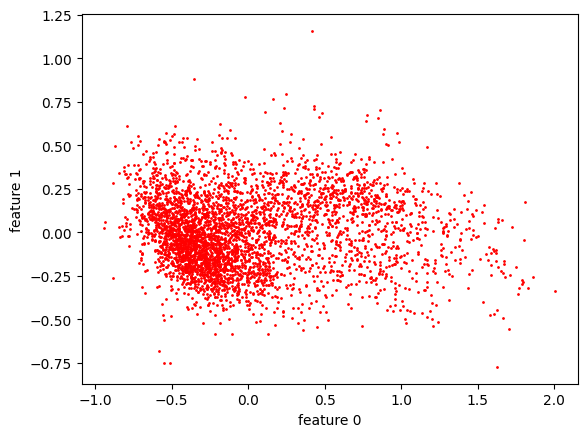

In [64]:
#plotting trasnformed features
print(np.shape(xseln3b_transformed[:,1]))
plt.plot(xseln3b_transformed[:,0],xseln3b_transformed[:,1],'ro',ms=1)
#label='component 13')
plt.xlabel("value")
plt.ylabel("value")
#plt.legend(loc="best")
plt.xlabel("feature 0")
plt.ylabel("feature 1")
#that are the features which look like that they are mainly containing real stars features 

Text(0, 0.5, 'feature 2')

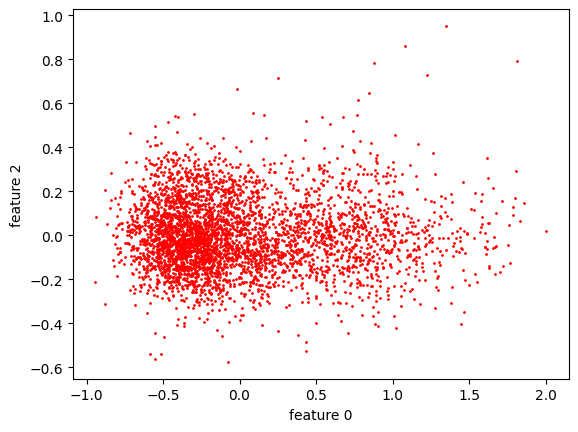

In [65]:
plt.plot(xseln3b_transformed[:,0],xseln3b_transformed[:,2],'ro',ms=1)
#label='component 13')
plt.xlabel("value")
plt.ylabel("value")
#plt.legend(loc="best")
plt.xlabel("feature 0")
plt.ylabel("feature 2")

Text(0, 0.5, 'feature 3')

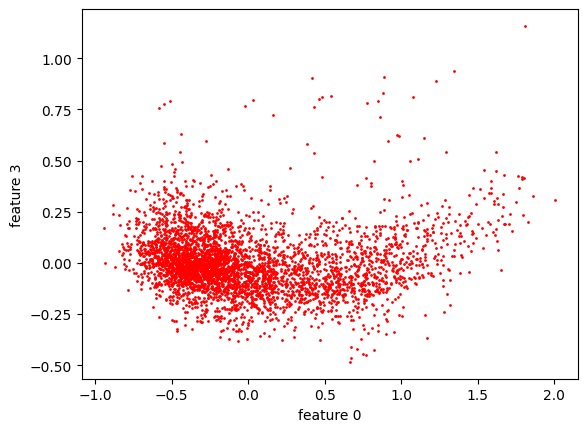

In [66]:
plt.plot(xseln3b_transformed[:,0],xseln3b_transformed[:,3],'ro',ms=1)
#label='component 13')
plt.xlabel("value")
plt.ylabel("value")
#plt.legend(loc="best")
plt.xlabel("feature 0")
plt.ylabel("feature 3")

Text(0, 0.5, 'feature 4')

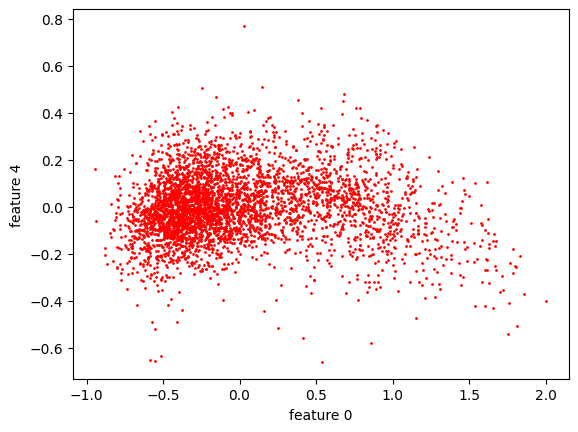

In [67]:
plt.plot(xseln3b_transformed[:,0],xseln3b_transformed[:,4],'ro',ms=1)
#label='component 13')
plt.xlabel("value")
plt.ylabel("value")
#plt.legend(loc="best")
plt.xlabel("feature 0")
plt.ylabel("feature 4")

Text(0, 0.5, 'feature 3')

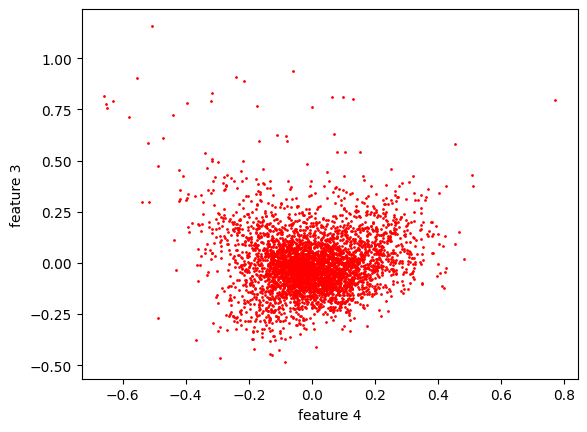

In [68]:
plt.plot(xseln3b_transformed[:,4],xseln3b_transformed[:,3],'ro',ms=1)
#label='component 13')
plt.xlabel("value")
plt.ylabel("value")
#plt.legend(loc="best")
plt.xlabel("feature 4")
plt.ylabel("feature 3")

There are no clear clusters besides the main one and ~3 point clusters. Thus, explore option outlier rejection. 

In [69]:
#outliers using component 2 to 11
stat=np.zeros((3,12))
for i in range(12):
    stat[0,i]=i
    stat[1,i]=np.median(xseln3b_transformed[:,i])
    stat[2,i]=(np.quantile(xseln3b_transformed[:,i],1-0.158)-np.quantile(xseln3b_transformed[:,i],0.158))/2   
print(np.round(stat.T,3))  

[[ 0.00e+00 -1.64e-01  5.34e-01]
 [ 1.00e+00 -8.00e-03  2.21e-01]
 [ 2.00e+00 -1.30e-02  1.57e-01]
 [ 3.00e+00 -1.40e-02  1.30e-01]
 [ 4.00e+00 -7.00e-03  1.31e-01]
 [ 5.00e+00 -2.40e-02  1.07e-01]
 [ 6.00e+00 -1.00e-03  1.08e-01]
 [ 7.00e+00  1.00e-03  9.30e-02]
 [ 8.00e+00  2.00e-03  9.80e-02]
 [ 9.00e+00  2.00e-03  9.80e-02]
 [ 1.00e+01 -0.00e+00  8.80e-02]
 [ 1.10e+01  1.00e-03  8.80e-02]]


In [70]:
meas=np.zeros((4,np.shape(xseln3b_transformed)[0]))
for i in range(np.shape(xseln3b_transformed)[0]):
    meas[0,i]=1
    meas[1,i]=1
    for j in range(2,12):
        meas[0,i]*=abs((xseln3b_transformed[i,j]-stat[1,j])/stat[2,j])
        meas[1,i]*=1/(stat[2,j]*np.sqrt(2*np.pi))*np.exp(-0.5*(xseln3b_transformed[i,j]-stat[1,j])**2/stat[2,j]**2)
    

maximum probability density is 374426.54242963257
maximum probability density is 4612.818571949891
minimum probability density is 1.1140589565087744e-58
5% quantile is 0.2745368299537187


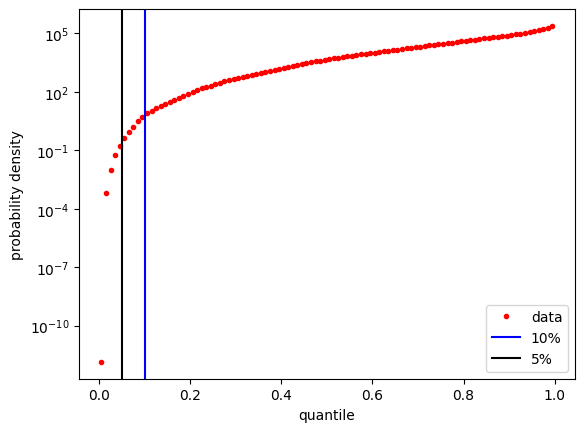

In [71]:
print(f"maximum probability density is {max(meas[1])}")
print(f"maximum probability density is {np.median(meas[1])}")
print(f"minimum probability density is {min(meas[1])}")
s=np.argsort(meas[1])
stat2=np.zeros((2,100))
for i in range(100):
    stat2[0,i]=(i+0.5)/100
    stat2[1,i]=np.quantile(meas[1],stat2[0,i])
plt.plot(stat2[0],stat2[1],'ro',ms=3,label='data')
#label='component 13')
plt.axvline(0.1,0,1,color='blue',label='10%')
plt.axvline(0.05,0,1,color='black',label='5%')
plt.xlabel("value")
plt.ylabel("value")
plt.yscale("log")
plt.legend(loc="best")
plt.xlabel("quantile")
plt.ylabel("probability density")  
print(f"5% quantile is {np.quantile(meas[1],0.05)}")

Text(0, 0.5, 'spectra')

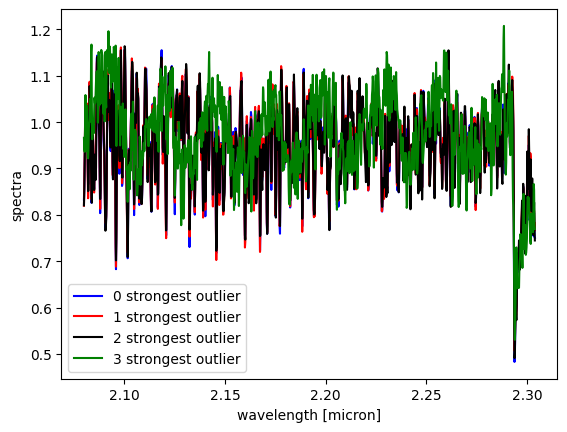

In [72]:
#plot some spectra too look per eye  
plt.plot(ressel2[3],xseln3b[:,s[0]],'b-',label='0 strongest outlier')
plt.plot(ressel2[3],xseln3b[:,s[1]],'r-',label='1 strongest outlier')
plt.plot(ressel2[3],xseln3b[:,s[2]],'k-',label='2 strongest outlier')
plt.plot(ressel2[3],xseln3b[:,s[3]],'g-',label='3 strongest outlier')
plt.legend(loc="best")
plt.xlabel("wavelength [micron]")
plt.ylabel("spectra")
#first 3 likely of same star with no waves but some noise not normal features

Text(0, 0.5, 'spectra')

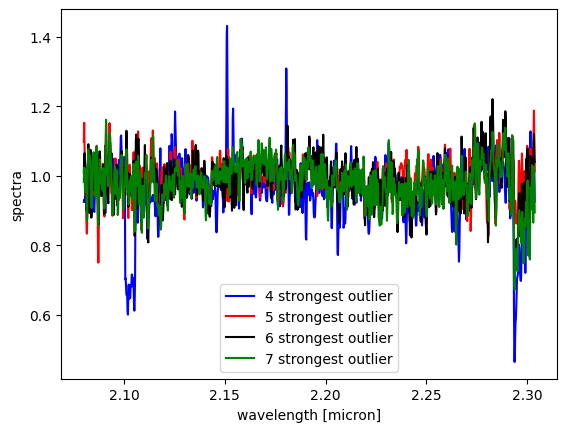

In [73]:
plt.plot(ressel2[3],xseln3b[:,s[4]],'b-',label='4 strongest outlier')
plt.plot(ressel2[3],xseln3b[:,s[5]],'r-',label='5 strongest outlier')
plt.plot(ressel2[3],xseln3b[:,s[6]],'k-',label='6 strongest outlier')
plt.plot(ressel2[3],xseln3b[:,s[7]],'g-',label='7 strongest outlier')
plt.legend(loc="best")
plt.xlabel("wavelength [micron]")
plt.ylabel("spectra")
#many have some other problem/ unusalness 

Text(0, 0.5, 'spectra')

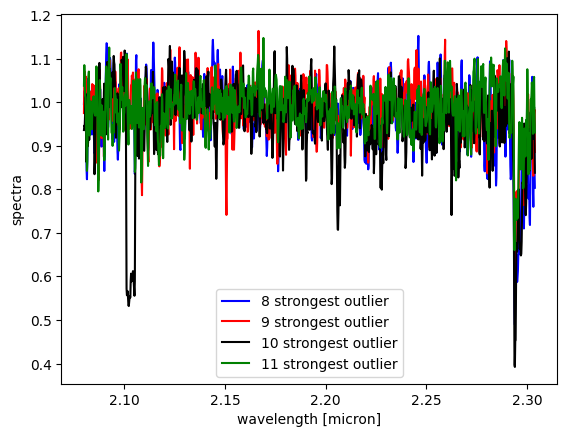

In [74]:
plt.plot(ressel2[3],xseln3b[:,s[8]],'b-',label='8 strongest outlier')
plt.plot(ressel2[3],xseln3b[:,s[9]],'r-',label='9 strongest outlier')
plt.plot(ressel2[3],xseln3b[:,s[10]],'k-',label='10 strongest outlier')
plt.plot(ressel2[3],xseln3b[:,s[11]],'g-',label='11 strongest outlier')
plt.legend(loc="best")
plt.xlabel("wavelength [micron]")
plt.ylabel("spectra")

Text(0, 0.5, 'spectra')

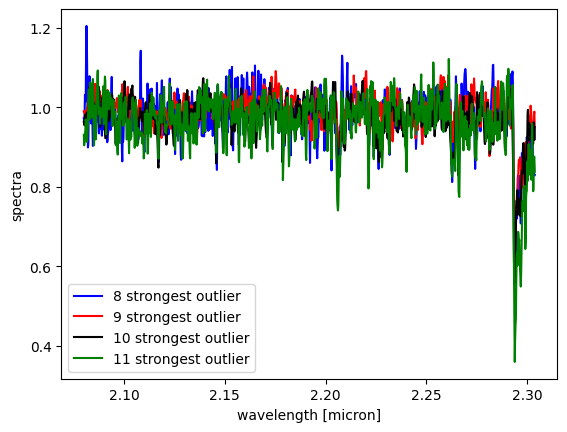

In [75]:
plt.plot(ressel2[3],xseln3b[:,s[208]],'b-',label='8 strongest outlier')
plt.plot(ressel2[3],xseln3b[:,s[209]],'r-',label='9 strongest outlier')
plt.plot(ressel2[3],xseln3b[:,s[210]],'k-',label='10 strongest outlier')
plt.plot(ressel2[3],xseln3b[:,s[211]],'g-',label='11 strongest outlier')
plt.legend(loc="best")
plt.xlabel("wavelength [micron]")
plt.ylabel("spectra")
#still waves at 5% partly

In [76]:
print(np.shape(callin_trans))
print(np.shape(cal_trans))

(107, 1000)
(107, 1000)


Text(0, 0.5, 'feature 1')

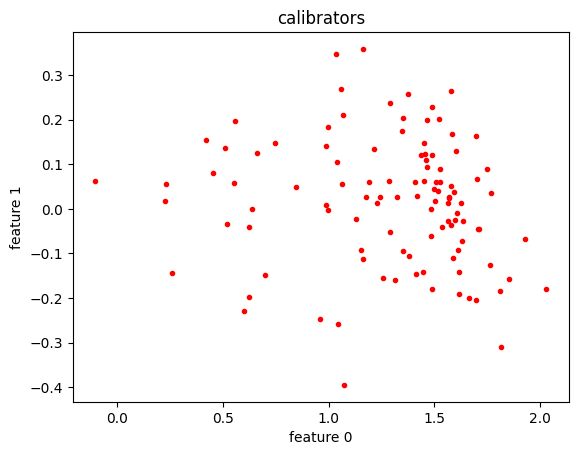

In [77]:
plt.plot(cal_trans[:,0],cal_trans[:,1],'ro',ms=3)
#label='component 13')
plt.xlabel("value")
plt.ylabel("value")
plt.title("calibrators")
#plt.legend(loc="best")
plt.xlabel("feature 0")
plt.ylabel("feature 1")

In [78]:
np.savetxt(path+"calibrators_3rdorder_pca_transformed.txt",cal_trans)
np.savetxt(path+"calibrators_linear_pca_transformed.txt",callin_trans)